> # <h1 style="text-align: center;"><b> Movies Clustering and Recommendation System </b></h1>

> # *Index*
1. Problem statement
2. Importing the libraries and the dataset
3. Understanding data
4. Cleaning data
5. Exploratory data analysis
6. Data preprocessing
7. Clusters implementation
8. Building content based recommendation system
9. Conclusions

> # *1. Problem statement*

* Netflix is the world's largest online streaming service provider, with over 200 million subscribers as of 2022. It is crucial that they effectively cluster the shows that are hosted on their platform in order to enhance the user experience, thereby preventing subscriber churn.

* We will be able to understand the shows that are similar to and different from one another by creating clusters, which may be leveraged to offer the consumers personalized show suggestions depending on their preferences.

* The goal of this project is to classify/group the Netflix shows into certain clusters such that the shows within a cluster are similar to each other and the shows in different clusters are dissimilar to each other.

> # *2. Importing the libraries and the dataset:*

In [184]:
# importing the required libraries

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime as dt
import dateparser

import warnings
warnings.filterwarnings('ignore')

from wordcloud import WordCloud, STOPWORDS
import re, string, unicodedata
import nltk

# import inflect

from bs4 import BeautifulSoup
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA

from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import string
string.punctuation
nltk.download('omw-1.4')
from nltk.tokenize import TweetTokenizer

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

import scipy.cluster.hierarchy as shc

sns.set()

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Surya\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Surya\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Surya\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [185]:
# reading data
path = 'netflix_movies_data.csv'

original_df = pd.read_csv(path,index_col='show_id')
df = original_df.copy()

> # *3. Understanding data:*

In [186]:
# top 3 rows
df.head(3)

type  title           director  \
show_id                                      
s1       TV Show     3%                NaN   
s2         Movie   7:19  Jorge Michel Grau   
s3         Movie  23:59       Gilbert Chan   

                                                      cast    country  \
show_id                                                                 
s1       João Miguel, Bianca Comparato, Michel Gomes, R...     Brazil   
s2       Demián Bichir, Héctor Bonilla, Oscar Serrano, ...     Mexico   
s3       Tedd Chan, Stella Chung, Henley Hii, Lawrence ...  Singapore   

                date_added  release_year rating   duration  \
show_id                                                      
s1         August 14, 2020          2020  TV-MA  4 Seasons   
s2       December 23, 2016          2016  TV-MA     93 min   
s3       December 20, 2018          2011      R     78 min   

                                                 listed_in  \
show_id                                                      
s1       International TV Shows, TV Dramas, TV Sci-Fi &...   
s2                            Dramas, International Movies   
s3                     Horror Movies, International Movies   

                                               description  
show_id                                                     
s1       In a future where the elite inhabit an island ...  
s2       After a devastating earthquake hits Mexico Cit...  
s3       When an army recruit is found dead, his fellow...

In [187]:
# dataframe shape
df.shape

(7787, 11)

* Dataset contains (7787 records) x (11 features).

In [188]:
# unique values in each column
df.nunique()

type               2
title           7787
director        4049
cast            6831
country          681
date_added      1565
release_year      73
rating            14
duration         216
listed_in        492
description     7769
dtype: int64

* # Feature Information
    * **show_id** : Unique ID for every Movie / Tv Show
    * **type** : Identifier - A Movie or TV Show
    * **title** : Title of the Movie / Tv Show
    * **director** : Director of the Movie
    * **cast** : Actors involved in the movie / show
    * **country** : Country where the movie / show was produced
    * **date_added** : Date it was added on Netflix
    * **release_year** : Actual Releaseyear of the movie / show
    * **rating** : TV Rating of the movie / show
    * **duration** : Total Duration - in minutes or number of seasons
    * **listed_in** : Genre
    * **description**: The Summary description

> # *4. Cleaning data:*

In [189]:
# Checking for duplicate records
print(df.duplicated())
df.duplicated().value_counts()

show_id
s1       False
s2       False
s3       False
s4       False
s5       False
         ...  
s7783    False
s7784    False
s7785    False
s7786    False
s7787    False
Length: 7787, dtype: bool


False    7787
Name: count, dtype: int64

* No duplicated records in the dataset.

<Axes: ylabel='show_id'>

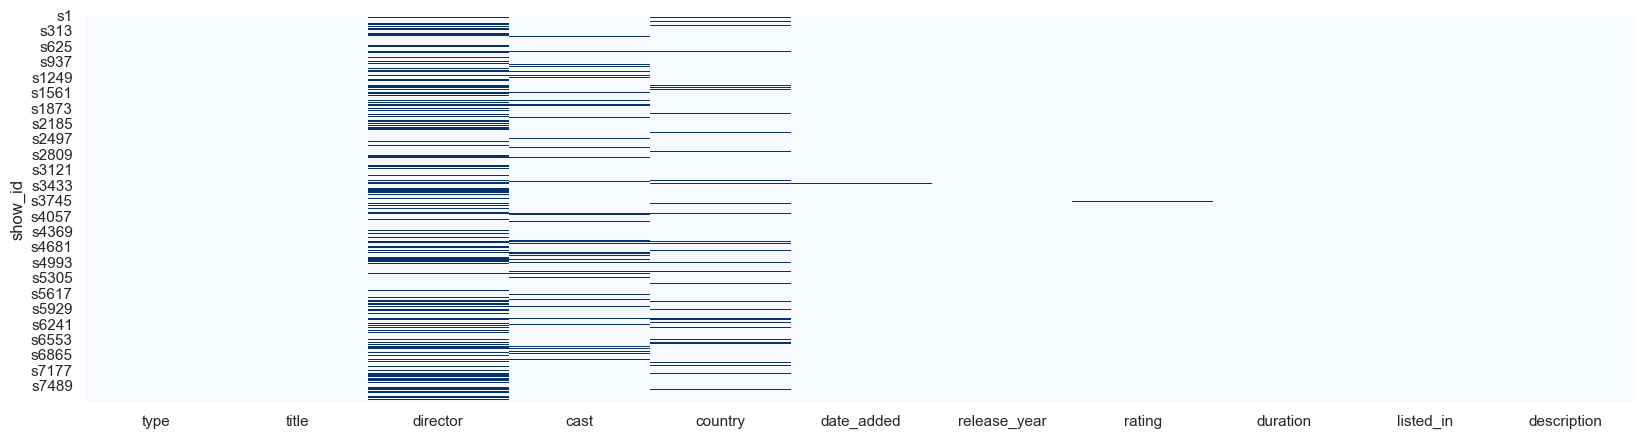

In [190]:
# Visualizing the missing values
# Checking Null Value by plotting Heatmap

plt.figure(figsize=(20,5))
sns.heatmap(df.isnull(), cbar=False,cmap='Blues')

In [191]:
# Missing values in the dataset
df.isna().sum()

type               0
title              0
director        2389
cast             718
country          507
date_added        10
release_year       0
rating             7
duration           0
listed_in          0
description        0
dtype: int64

* Missing values exists in following features : 
    - director
    - cast
    - country
    - rating columns
    - date_added
* Missing values in the "director", "cast", and "country" attributes can be replaced with "Unknown".
* Missing values in rating can be imputed with its mode, since this attribute is discrete.
* 10 records in the date_added column can be dropped.

In [192]:
# Handling the missing values

# filling 3 attribute's missing values with "Unknown"
df[['director','cast','country']] = df[['director','cast','country']].fillna('Unknown')

# filling missing rating with most frequent value
df['rating'] = df['rating'].fillna(df['rating'].mode()[0])

In [193]:
# droping the remaining 10 rows with missing values of date_added attribute
df.dropna(axis=0, inplace = True)
df.shape

(7777, 11)

* 10 records dropped
* (7787 records) x (11 features)  ->  (7777 records) x (11 features).

In [194]:
df.isna().sum()

type            0
title           0
director        0
cast            0
country         0
date_added      0
release_year    0
rating          0
duration        0
listed_in       0
description     0
dtype: int64

* Handled all the missing values.

In [195]:
# Top countries
df.country.value_counts()

country
United States                                                   2549
India                                                            923
Unknown                                                          506
United Kingdom                                                   396
Japan                                                            225
                                                                ... 
Russia, United States, China                                       1
Italy, Switzerland, France, Germany                                1
United States, United Kingdom, Canada                              1
United States, United Kingdom, Japan                               1
Sweden, Czech Republic, United Kingdom, Denmark, Netherlands       1
Name: count, Length: 682, dtype: int64

In [196]:
# Genre of shows
df.listed_in.value_counts()

listed_in
Documentaries                                                                      334
Stand-Up Comedy                                                                    321
Dramas, International Movies                                                       320
Comedies, Dramas, International Movies                                             243
Dramas, Independent Movies, International Movies                                   215
                                                                                  ... 
Anime Series, Crime TV Shows, TV Thrillers                                           1
Crime TV Shows, Romantic TV Shows, Spanish-Language TV Shows                         1
Crime TV Shows, International TV Shows, Reality TV                                   1
International Movies, Romantic Movies, Sci-Fi & Fantasy                              1
International TV Shows, Spanish-Language TV Shows, Stand-Up Comedy & Talk Shows      1
Name: count, Length: 491, dtype: 

* Some movies / TV shows that were filmed in multiple countries, have multiple genres associated with it.
* Considering only the primary genre and country where that respective movie / TV show was filmed, To simplify the analysis.

In [197]:
# Choosing the primary country and primary genre
df['country'] = df['country'].apply(lambda x: x.split(',')[0])
df['listed_in'] = df['listed_in'].apply(lambda x: x.split(',')[0])

In [198]:
# contry in which a movie was produced
df.country.value_counts()

country
United States     2877
India              956
United Kingdom     576
Unknown            506
Canada             259
                  ... 
Zimbabwe             1
Namibia              1
Soviet Union         1
Iran                 1
Somalia              1
Name: count, Length: 82, dtype: int64

In [199]:
# genre of shows
df.listed_in.value_counts()

listed_in
Dramas                          1384
Comedies                        1074
Documentaries                    751
Action & Adventure               721
International TV Shows           689
Children & Family Movies         502
Crime TV Shows                   369
Kids' TV                         357
Stand-Up Comedy                  321
Horror Movies                    244
British TV Shows                 231
Docuseries                       193
Anime Series                     147
International Movies             114
TV Comedies                      109
Reality TV                       102
Classic Movies                    77
TV Dramas                         62
Movies                            56
Thrillers                         49
TV Action & Adventure             36
Stand-Up Comedy & Talk Shows      33
Romantic TV Shows                 28
Independent Movies                20
Anime Features                    19
Classic & Cult TV                 19
Music & Musicals            

In [200]:
# Converting Duration string value to integer
df['duration']

show_id
s1       4 Seasons
s2          93 min
s3          78 min
s4          80 min
s5         123 min
           ...    
s7783       99 min
s7784      111 min
s7785       44 min
s7786     1 Season
s7787       90 min
Name: duration, Length: 7777, dtype: object

In [201]:
# Splitting the duration column, and changing the datatype to integer
df['duration'] = df['duration'].apply(lambda x: int(x.split()[0]))

In [202]:
# Number of seasons for tv shows
df[df['type']=='TV Show']['duration'].value_counts()

duration
1     1608
2      378
3      183
4       86
5       57
6       30
7       19
8       18
9        8
10       5
11       2
12       2
15       2
13       1
16       1
Name: count, dtype: int64

In [203]:
# Movie length in minutes
df[df['type']=='Movie']['duration'].value_counts()

duration
90     136
93     131
91     125
94     125
95     119
      ... 
214      1
182      1
224      1
233      1
191      1
Name: count, Length: 201, dtype: int64

In [204]:
# datatype of duration
df.duration.dtype

dtype('int64')

* Successfully converted the datatype of duration column to int.

In [205]:
# Typecasting 'date_added' from string to datetime
df["date_added"] = df["date_added"].apply(dateparser.parse)

In [206]:
# first and last date on which a show was added on Netflix
df.date_added.min(),df.date_added.max()

(Timestamp('2008-01-01 00:00:00'), Timestamp('2021-01-16 00:00:00'))

* Available data is between 1st January 2008 and 16th January 2021.

In [207]:
# Adding new attributes month and year of date added
df['month_added'] = df['date_added'].dt.month
df['year_added'] = df['date_added'].dt.year
df.drop('date_added', axis=1, inplace=True)

<Axes: xlabel='rating', ylabel='count'>

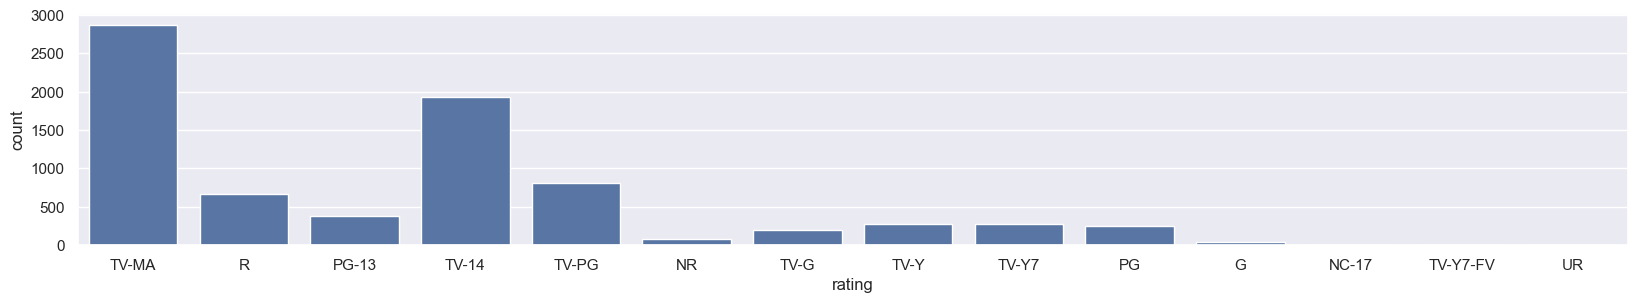

In [208]:
# Age ratings for shows in the dataset
plt.figure(figsize=(20,3))
sns.countplot(x='rating',data=df)

In [209]:
# Age ratings
df.rating.unique()

array(['TV-MA', 'R', 'PG-13', 'TV-14', 'TV-PG', 'NR', 'TV-G', 'TV-Y',
       'TV-Y7', 'PG', 'G', 'NC-17', 'TV-Y7-FV', 'UR'], dtype=object)

* [Ratings](https://en.wikipedia.org/wiki/TV_Parental_Guidelines) can be changed to age restrictions that apply on certain movies and TV shows.

In [210]:
# Changing the values in the rating column
rating_map = {'TV-MA':'Adults',
              'R':'Adults',
              'PG-13':'Teens',
              'TV-14':'Young Adults',
              'TV-PG':'Older Kids',
              'NR':'Adults',
              'TV-G':'Kids',
              'TV-Y':'Kids',
              'TV-Y7':'Older Kids',
              'PG':'Older Kids',
              'G':'Kids',
              'NC-17':'Adults',
              'TV-Y7-FV':'Older Kids',
              'UR':'Adults'}

df['rating'].replace(rating_map, inplace = True)
df['rating'].unique()

array(['Adults', 'Teens', 'Young Adults', 'Older Kids', 'Kids'],
      dtype=object)

<Axes: xlabel='rating', ylabel='count'>

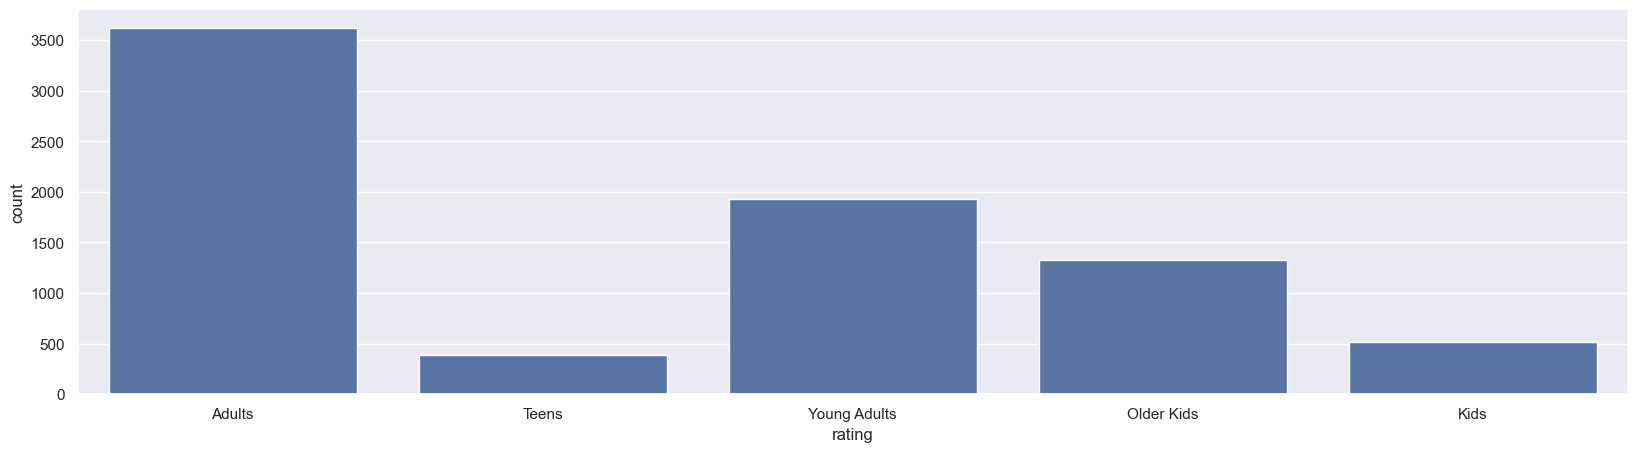

In [211]:
# Age ratings for shows in the dataset
plt.figure(figsize=(20,5))
sns.countplot(x='rating',data=df)

* Around 45% of shows on Netflix are produced for adult audience. Followed by young adults, older kids. 
* Netflix has the least number of shows that are specifically produced for teenagers and kids than other age groups.

> # *5. Exploratory Data Analysis:*

# *Univariate Analysis:*

Text(0.5, 1.0, 'Movies and TV Shows')

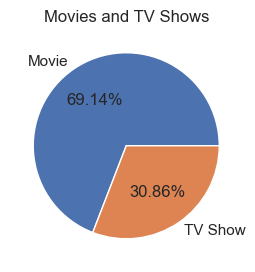

In [212]:
# Number of Movies and TV Shows in the dataset
plt.figure(figsize=(3,5))
df.type.value_counts().plot(kind='pie',autopct='%.2f%%')
plt.ylabel('')
plt.title('Movies and TV Shows')

Text(0.5, 1.0, 'Top 10 directors by number of shows directed')

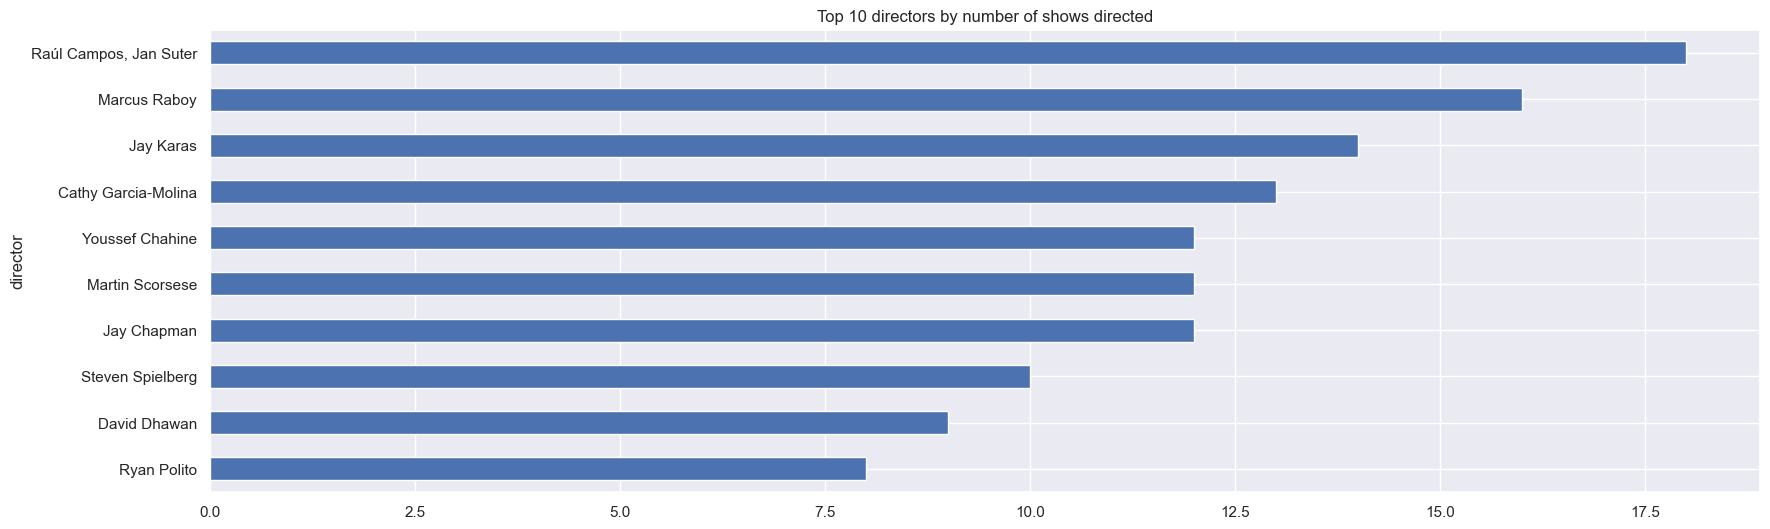

In [213]:
# Top 10 directors in the dataset
plt.figure(figsize=(20,6))
df[~(df['director']=='Unknown')]['director'].value_counts().nlargest(10).iloc[::-1].plot(kind='barh')
plt.title('Top 10 directors by number of shows directed')

Text(0.5, 1.0, ' Top 10 countries with the highest number of shows')

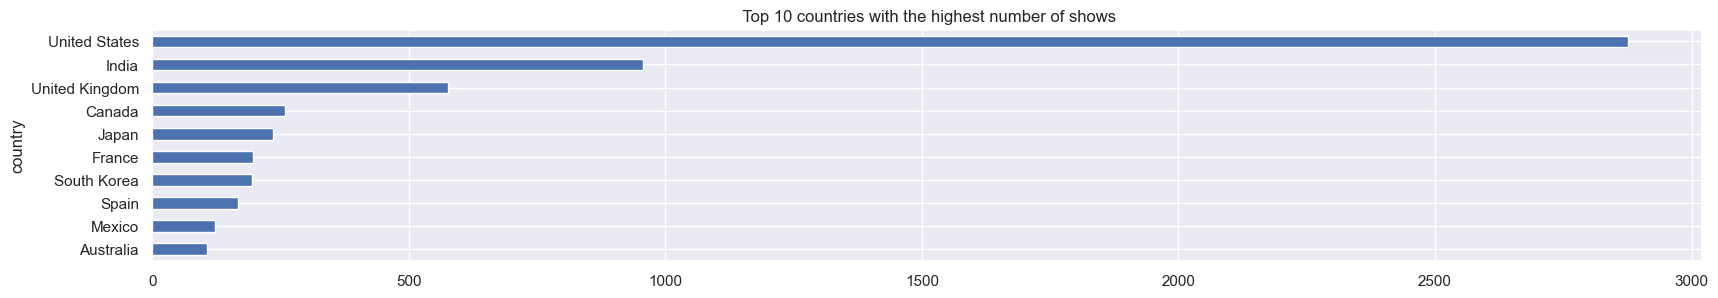

In [214]:
# Top 10 countries with the highest number movies / TV shows in the dataset
plt.figure(figsize=(20,3))
df[~(df['country']=='Unknown')]['country'].value_counts().nlargest(10).iloc[::-1].plot(kind='barh')
plt.title(' Top 10 countries with the highest number of shows')

In [215]:
# % share of movies / tv shows by top 3 & top 10 countries
print("Share of movies / tv shows by top 3 countries : ",round(df['country'].value_counts().nlargest(3).sum()/len(df)*100,2),"%")
print("Share of movies / tv shows by top 10 countries : ",round(df['country'].value_counts().nlargest(10).sum()/len(df)*100,2),"%")

Share of movies / tv shows by top 3 countries :  56.69 %
Share of movies / tv shows by top 10 countries :  78.32 %


* **The top 3 countries together account for about 56% of all movies and TV shows in the dataset.**
* **This value increases to about 78% for top ten countries.**

Text(0.5, 1.0, 'distribution by released year')

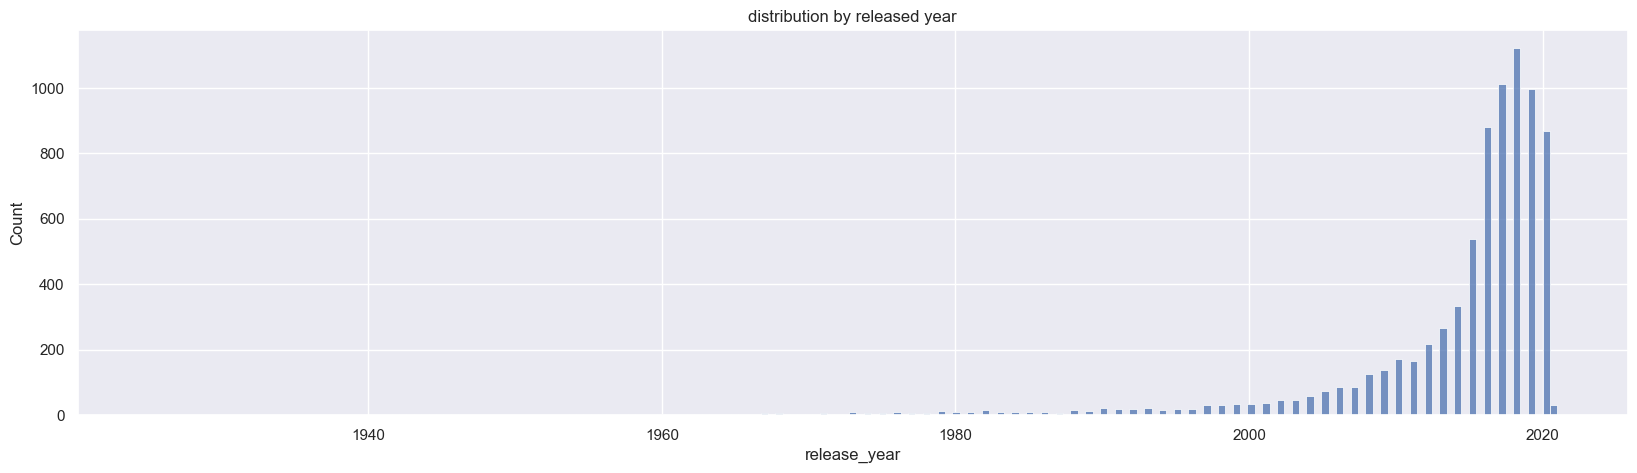

In [216]:
# Visualizing the year in which the movie / tv show was released
plt.figure(figsize=(20,5))
sns.histplot(df['release_year'])
plt.title('distribution by released year')

* Netflix has more number of new movies / TV shows than the old ones.

Text(0.5, 1.0, 'Top 10 genres')

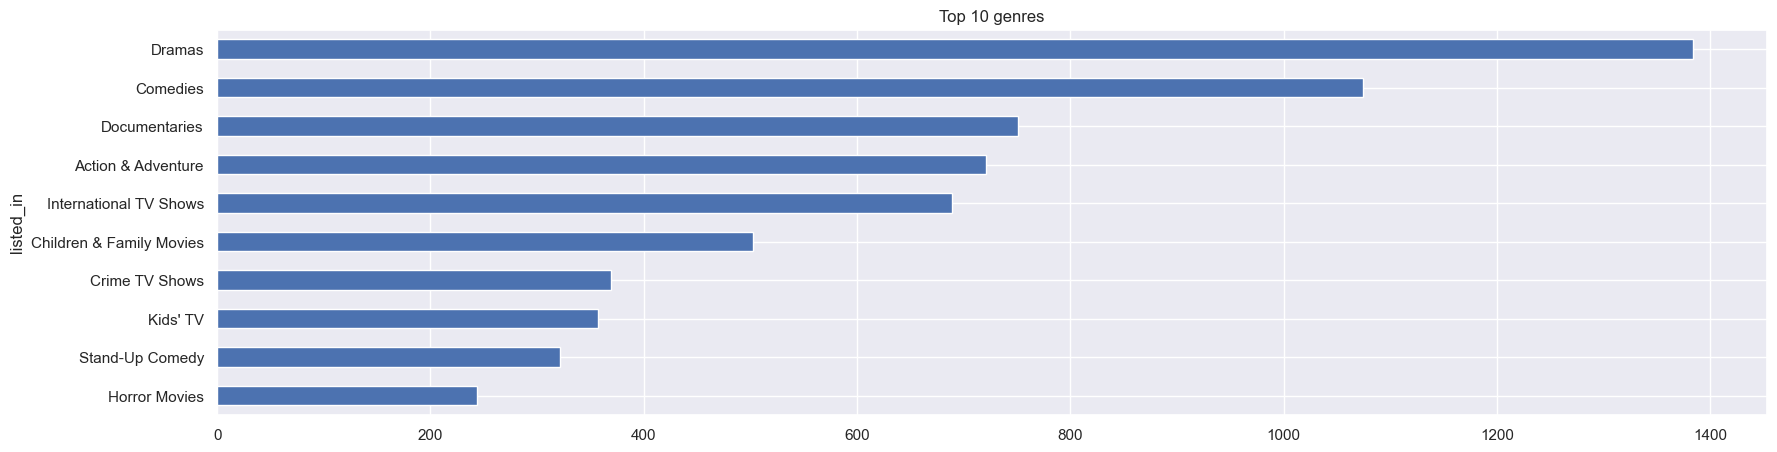

In [217]:
# Top 10 genres 
plt.figure(figsize=(20,5))
df['listed_in'].value_counts().nlargest(10).iloc[::-1].plot(kind='barh')
plt.title('Top 10 genres')

In [218]:
# Share of top 3 and top 10 genres
print("% Share of top 3 genres :",round(df['listed_in'].value_counts().nlargest(3).sum()/len(df)*100,2),"%")
print("% Share of top 10 genres :",round(df['listed_in'].value_counts().nlargest(10).sum()/len(df)*100,2),"%")

% Share of top 3 genres : 41.26 %
% Share of top 10 genres : 82.45 %


* The dramas is the most popular genre followed by comedies and documentaries.**
* These three genres account for about 41% of all movies and TV shows.**
* This value increases to about 82% for top 10 genres.**

Text(0.5, 0, '')

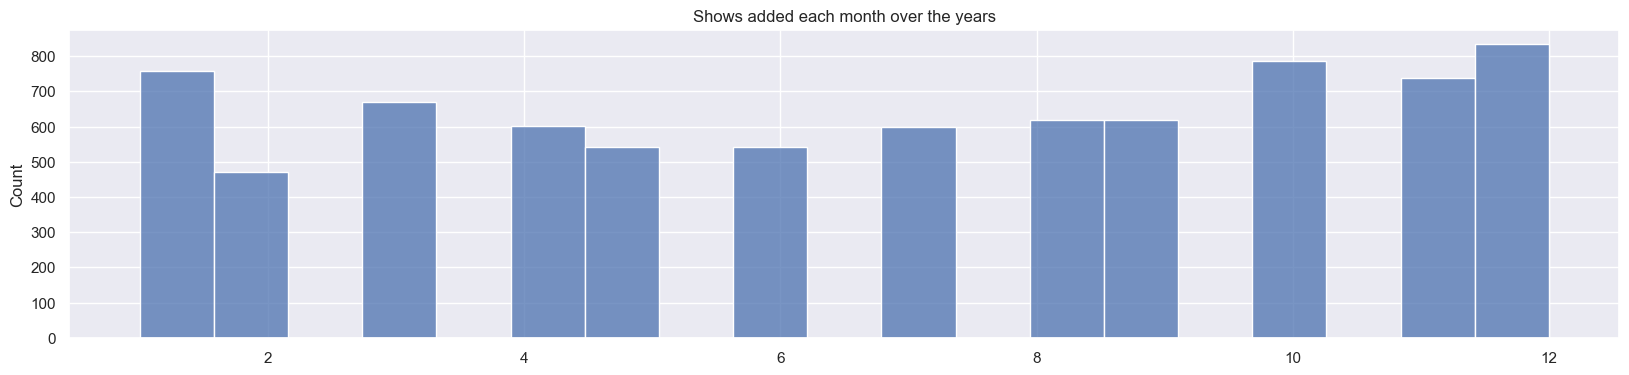

In [219]:
# Number of shows added on different months
plt.figure(figsize = (20,4)) 
sns.histplot(df['month_added'])
plt.title('Shows added each month over the years')
plt.xlabel('')

* Over the years a greater number of shows were added in the months of October, November, December, and January.

Text(0.5, 0, '')

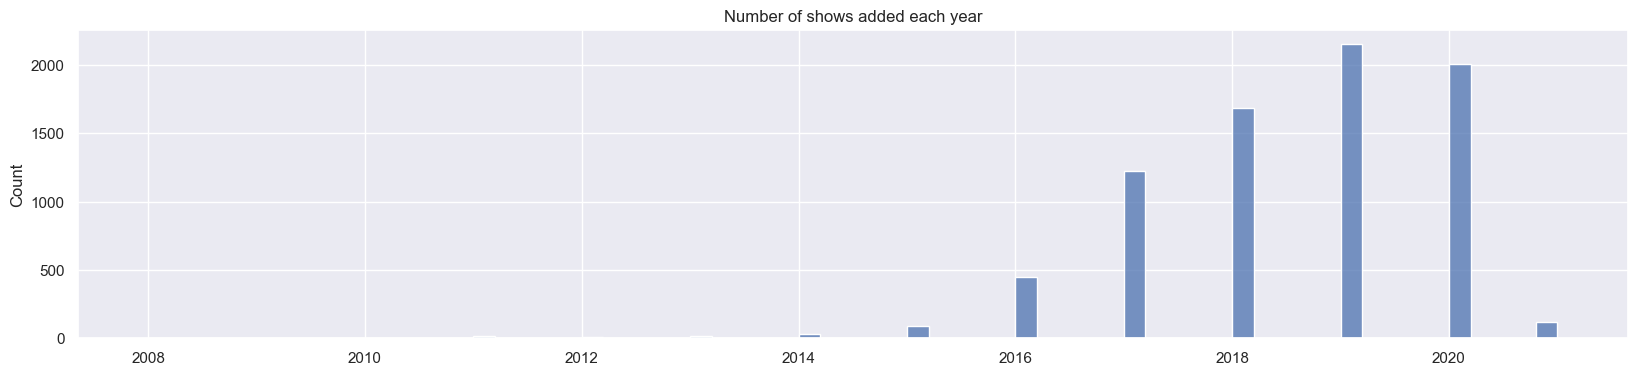

In [220]:
# Number of shows added over the years
plt.figure(figsize = (20,4)) 
sns.histplot(df['year_added'])
plt.title('Number of shows added each year')
plt.xlabel('')

* Netflix continuous to add more shows on its platform over the years.
* There is a decrease in the number of shows added in the year 2020, which might be attributed to the covid-19-induced lockdowns, which halted the creation of shows.
* We have Netflix data only up to 16th January 2021, hence there are less movies added in this year.

Text(0.5, 1.0, 'Number of shows on Netflix for different age groups')

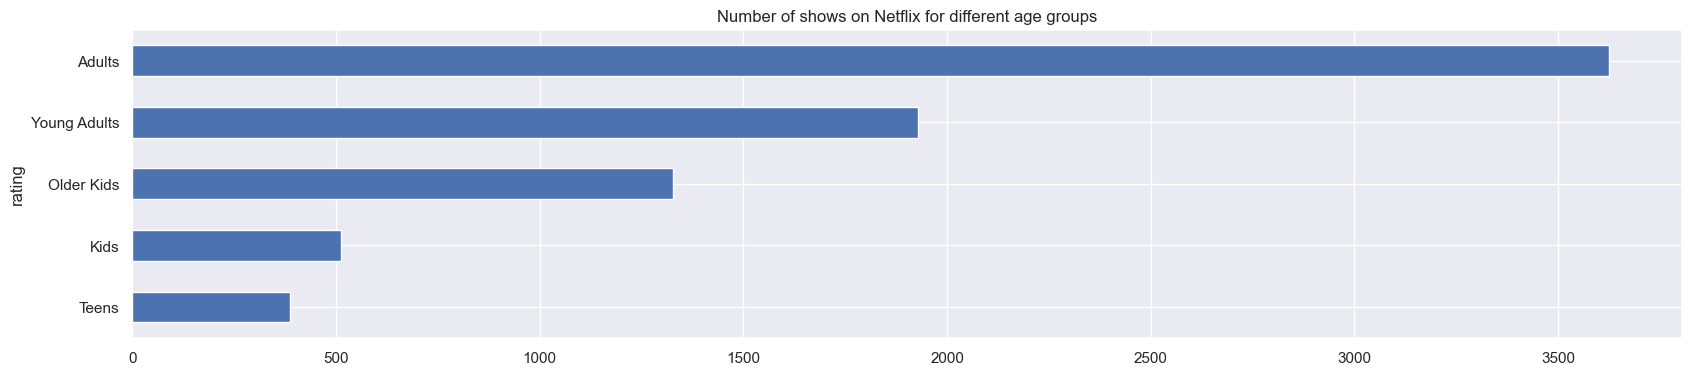

In [221]:
# Number of shows on Netflix for different age groups
plt.figure(figsize=(20,4))
df.rating.value_counts().iloc[::-1].plot(kind='barh')
plt.title('Number of shows on Netflix for different age groups')

* The majority of the shows on Netflix are catered to the needs of adult and young adult population.

# *Bivariate analysis:*

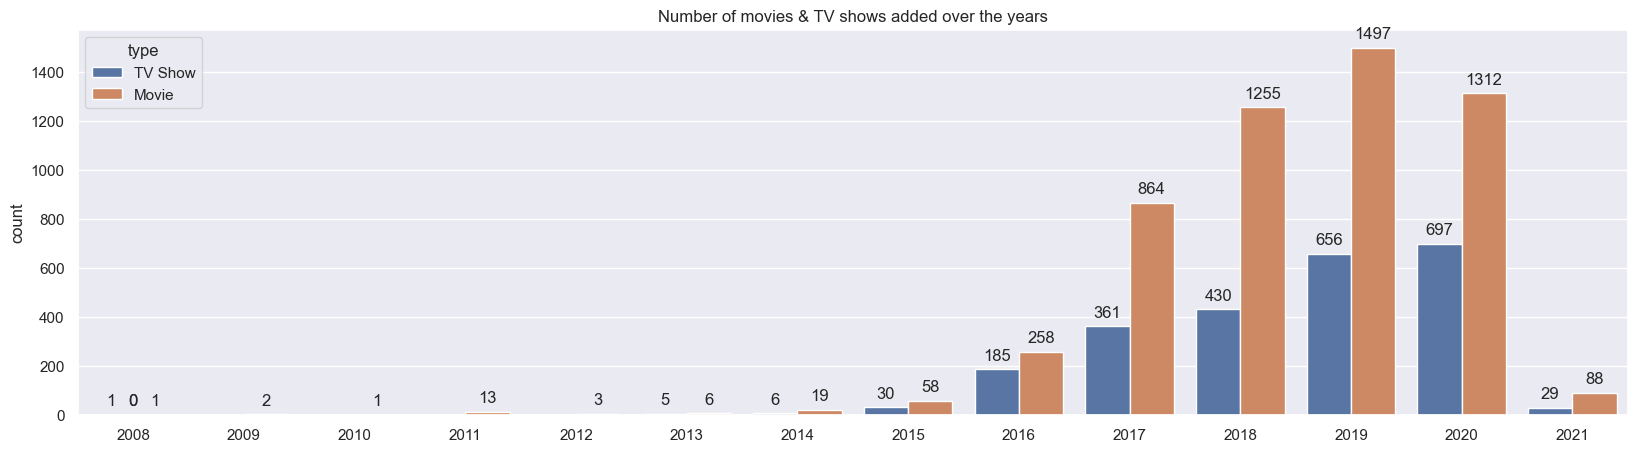

In [222]:
# Number of movies and TV shows added over the years
plt.figure(figsize=(20,5))
p = sns.countplot(x='year_added',data=df, hue='type')
plt.title('Number of movies & TV shows added over the years')
plt.xlabel('')
for i in p.patches:
  p.annotate(format(i.get_height(), '.0f'), (i.get_x() + i.get_width() / 2., i.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

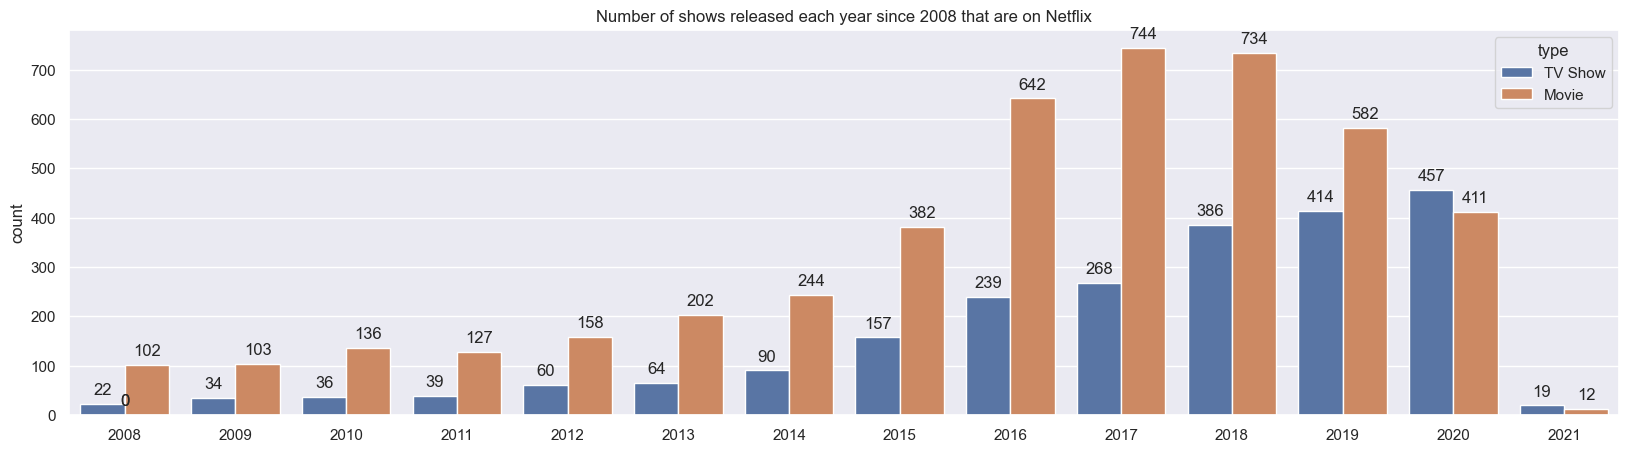

In [223]:
# Number of shows released each year since 2008
order = range(2008,2022)
plt.figure(figsize=(20,5))
p = sns.countplot(x='release_year',data=df, hue='type',
                  order = order)
plt.title('Number of shows released each year since 2008 that are on Netflix')
plt.xlabel('')
for i in p.patches:
  p.annotate(format(i.get_height(), '.0f'), (i.get_x() + i.get_width() / 2., i.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

* Over the years, Netflix has consistently focused on adding more shows in its platform.
* Though there was a decrease in the number of movies added in 2020, this pattern did not exist in the number of TV shows added in the same year.
* This might signal that Netflix is increasingly concentrating on introducing more TV series to its platform rather than movies.

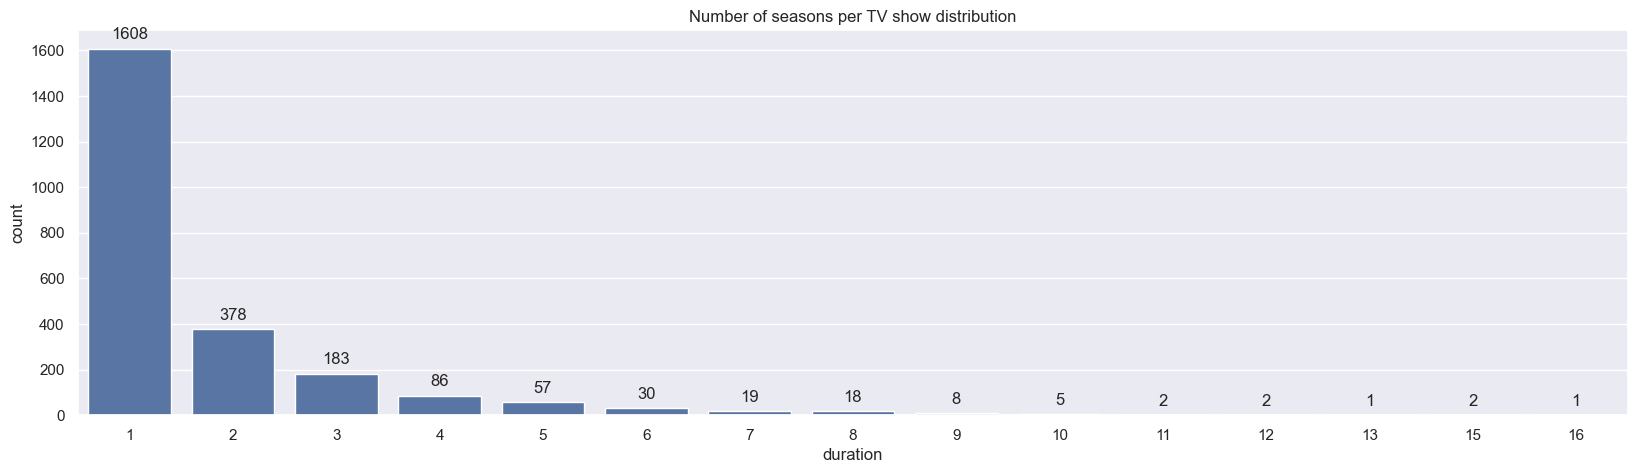

In [224]:
# Seasons in each TV show
plt.figure(figsize=(20,5))
p = sns.countplot(x='duration',data=df[df['type']=='TV Show'])
plt.title('Number of seasons per TV show distribution')

for i in p.patches:
  p.annotate(format(i.get_height(), '.0f'), (i.get_x() + i.get_width() / 2., i.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

In [225]:
# % of tv shows with just 1 season
print(" % of tv shows with just 1 season :",len(df[(df['type']=='TV Show') & (df['duration']==1)]) / len(df[df['type']=='TV Show'])* 100,'%')

 % of tv shows with just 1 season : 67.0 %


* The TV series in the dataset have up to 16 seasons, however the bulk of them only have one. This might mean that the majority of TV shows has only recently begun, and that further seasons are on the way.
* There are very few TV shows that have more than 8 seasons.

Text(0.5, 1.0, 'Movie duration distribution')

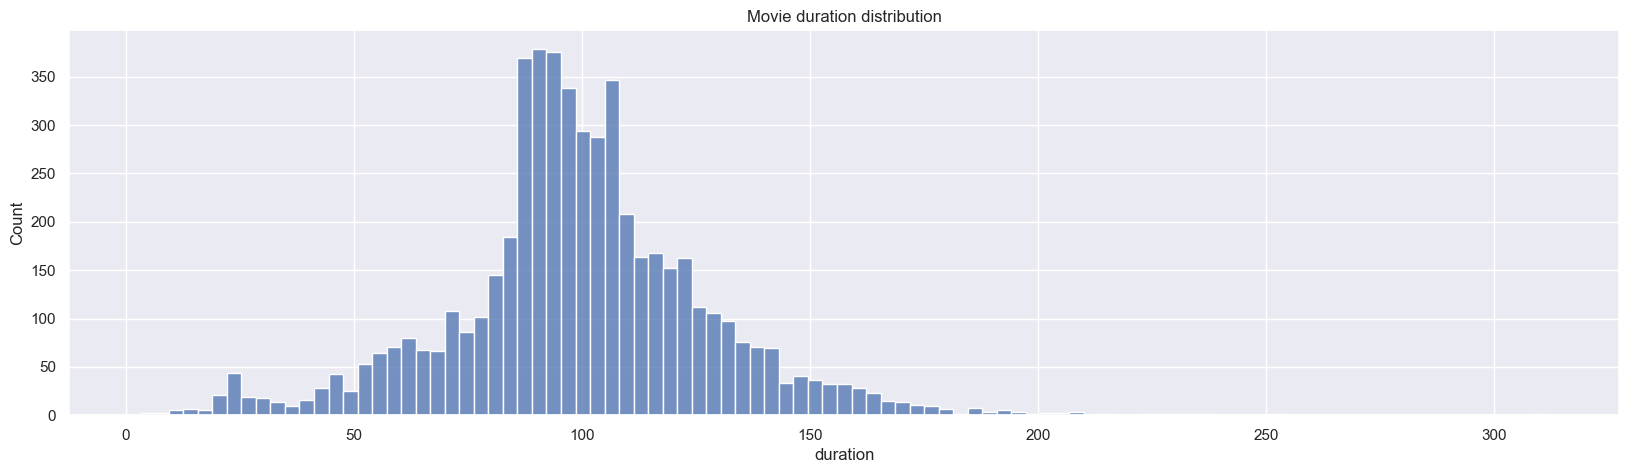

In [226]:
# length of movie analysis
plt.figure(figsize=(20,5))
sns.histplot(x='duration',data=df[df['type']=='Movie'])
plt.title('Movie duration distribution')

In [227]:
# Movie statistics
df[df['type']== 'Movie']['duration'].describe()

count    5377.000000
mean       99.307978
std        28.530881
min         3.000000
25%        86.000000
50%        98.000000
75%       114.000000
max       312.000000
Name: duration, dtype: float64

* The length of a movie may range from 3 min to 312 minutes, and the distribution is almost normally distributed.

Text(0.5, 0, 'Year')

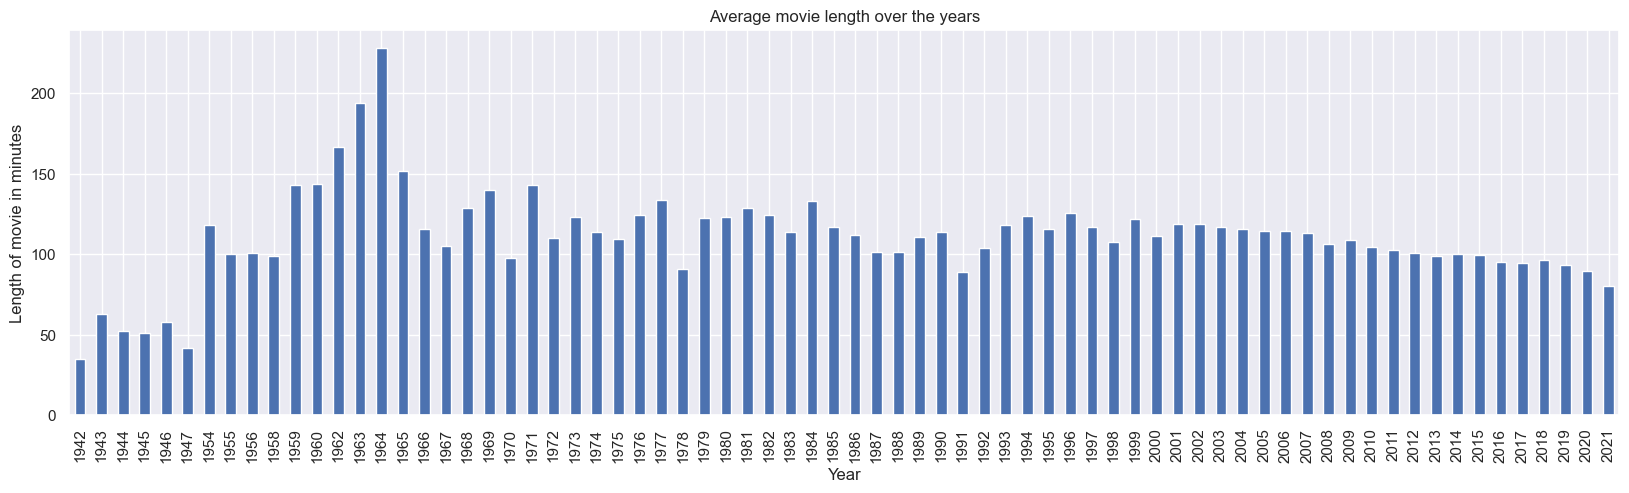

In [228]:
# Average movie length over the years
plt.figure(figsize=(20,5))
df[df['type']=='Movie'].groupby('release_year')['duration'].mean().plot(kind='bar')
plt.title('Average movie length over the years')
plt.ylabel('Length of movie in minutes')
plt.xlabel('Year')

In [229]:
# Movie release year statistics
df[df['type']== 'Movie']['release_year'].describe()

count    5377.000000
mean     2012.920030
std         9.663282
min      1942.000000
25%      2012.000000
50%      2016.000000
75%      2018.000000
max      2021.000000
Name: release_year, dtype: float64

* Netflix has several movies on its site, including those that were released in way back 1942.
* As per the plot, movies made in the 1940s had a fairly short duration on average.
* On average, movies made in the 1960s have the longest movie length.
* The average length of a movie has been continuously decreasing since the 2000s.

Text(0.5, 1.0, 'Top 10 genres for movies')

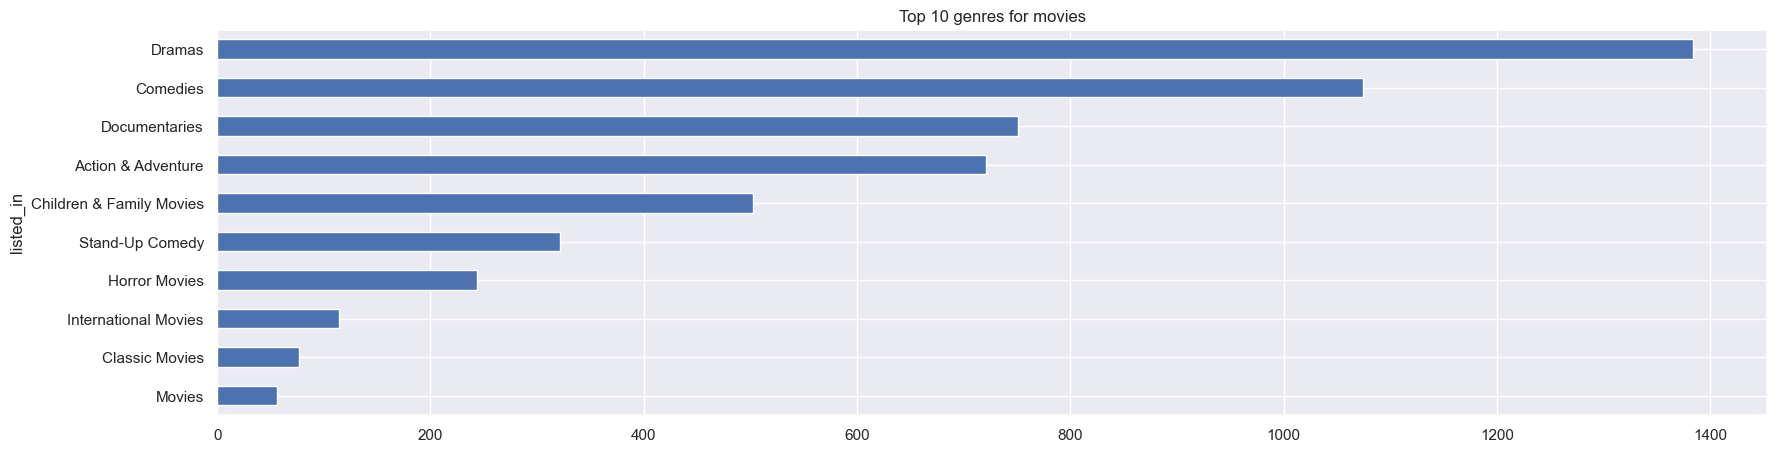

In [230]:
# Top 10 genre for movies
plt.figure(figsize=(20,5))
df[df['type']=='Movie']['listed_in'].value_counts().nlargest(10).iloc[::-1].plot(kind='barh')
plt.title('Top 10 genres for movies')

* Dramas, comedies, and documentaries are the most popular genre for the movies on Netflix.

Text(0.5, 1.0, 'Top 10 genres for TV Shows')

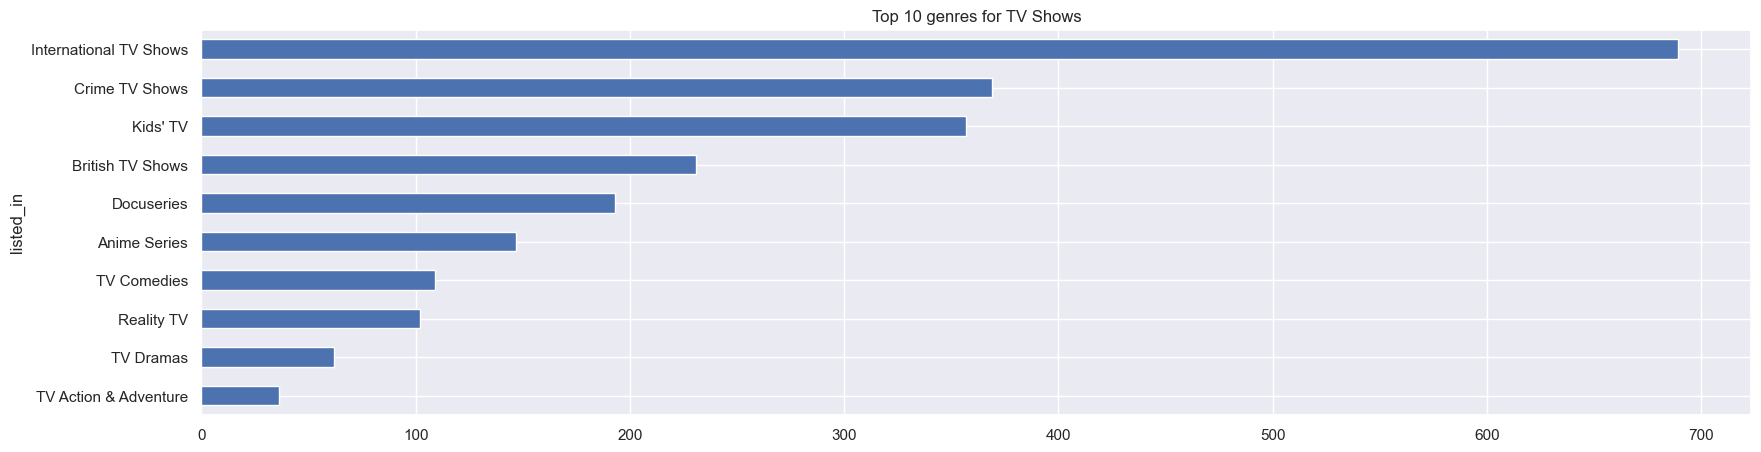

In [231]:
# Top 10 genre for tv shows
plt.figure(figsize=(20,5))
df[df['type']=='TV Show']['listed_in'].value_counts().nlargest(10).iloc[::-1].plot(kind='barh')
plt.title('Top 10 genres for TV Shows')

* International, crime, and kids are the most popular genre for TV shows on Netflix.

Text(0.5, 1.0, 'Top 10 movie directors')

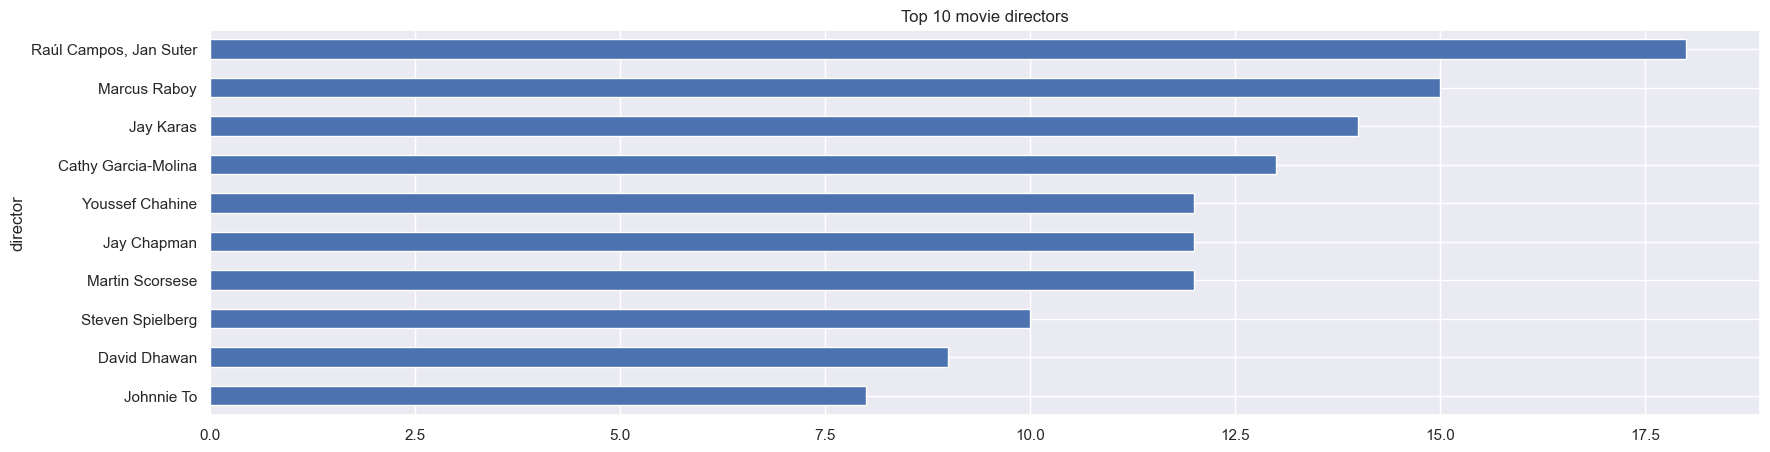

In [232]:
# Top 10 movie directors
plt.figure(figsize=(20,5))
df[~(df['director']=='Unknown') & (df['type']=='Movie')]['director'].value_counts().nlargest(10).iloc[::-1].plot(kind='barh')
plt.title('Top 10 movie directors')

* Raul Campos and Jan Suter have togather directed in 18 movies, higher than anyone yet.
* This is followed by Marcus Roboy, Jay Karas, and Cathy Gracia-Molina

Text(0.5, 1.0, 'Top 10 TV show directors')

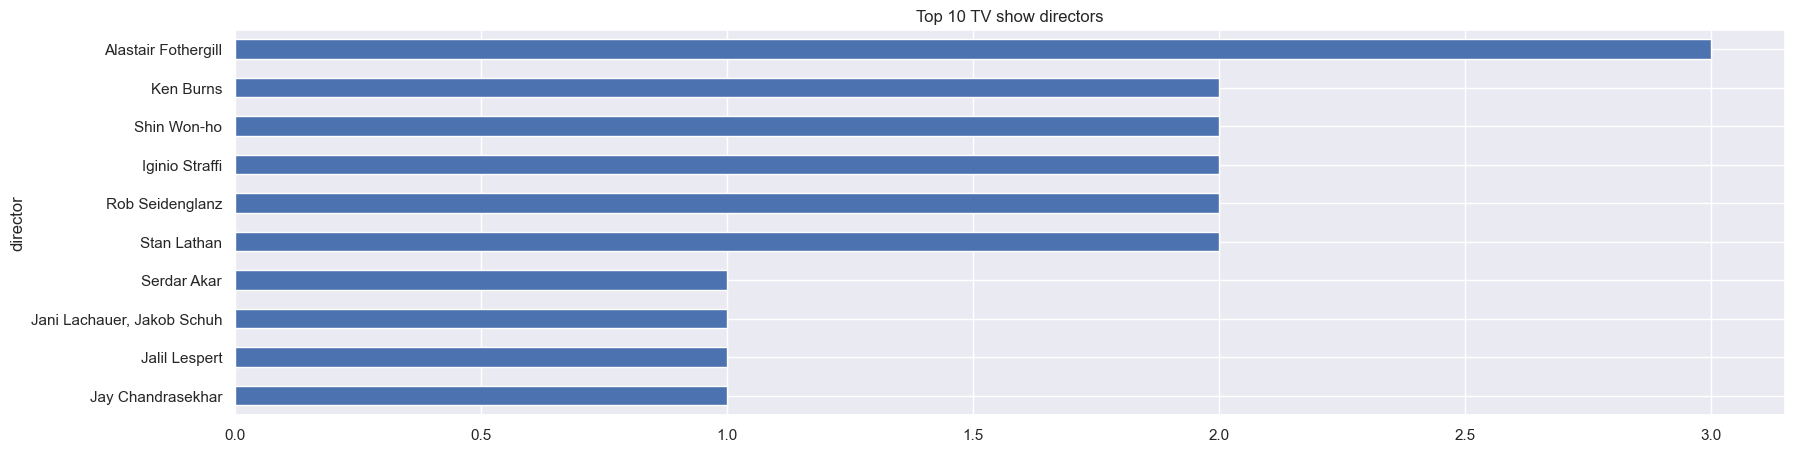

In [233]:
# Top 10 TV show directors
plt.figure(figsize=(20,5))
df[~(df['director']=='Unknown') & (df['type']=='TV Show')]['director'].value_counts().nlargest(10).iloc[::-1].plot(kind='barh')
plt.title('Top 10 TV show directors')

* Alastair Fothergill has directed three TV shows, the most of any director.
* Only six directors have directed more than one television show.

Text(0.5, 1.0, 'Actors who have appeared in highest number of movies')

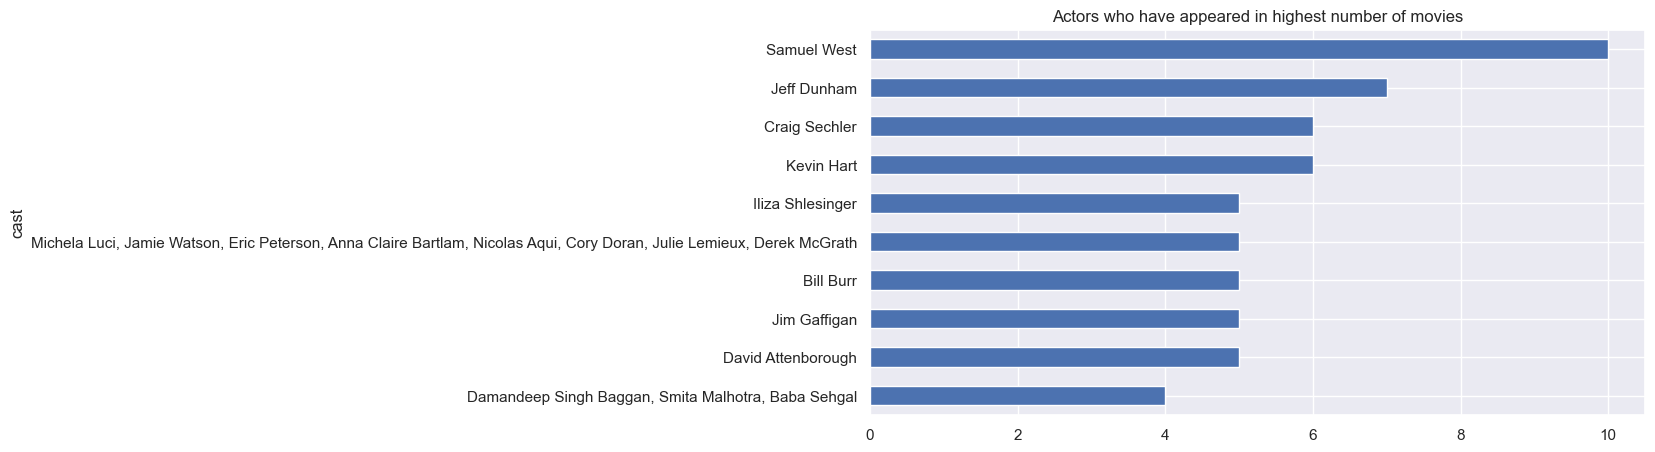

In [234]:
# Top actors 10 for movies
plt.figure(figsize=(10,5))
df[~(df['cast']=='Unknown') & (df['type']=='Movie')]['cast'].value_counts().nlargest(10).iloc[::-1].plot(kind='barh')
plt.title('Actors who have appeared in highest number of movies')

* Samuel West has appeared in 10 movies, followed by Jeff Dunham with 7 movies.

Text(0.5, 1.0, 'Actors who have appeared in highest number of TV shows')

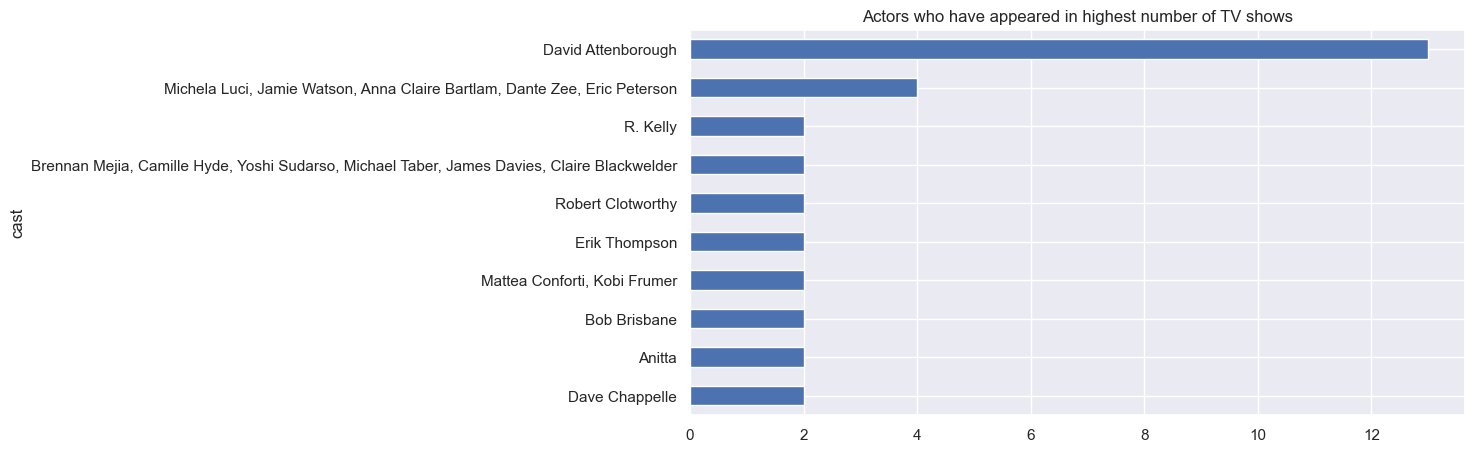

In [235]:
# Top actors for TV shows
plt.figure(figsize=(10,5))
df[~(df['cast']=='Unknown') & (df['type']=='TV Show')]['cast'].value_counts().nlargest(10).iloc[::-1].plot(kind='barh')
plt.title('Actors who have appeared in highest number of TV shows')

* David Attenborough has appeared in 13 TV shows, followed by Michela Luci, Jamie Watson, Anna Claire Bartlam, Dante Zee, Eric Peterson with 4 TV shows.

In [236]:
df['description'].values

array(['In a future where the elite inhabit an island paradise far from the crowded slums, you get one chance to join the 3% saved from squalor.',
       'After a devastating earthquake hits Mexico City, trapped survivors from all walks of life wait to be rescued while trying desperately to stay alive.',
       "When an army recruit is found dead, his fellow soldiers are forced to confront a terrifying secret that's haunting their jungle island training camp.",
       ...,
       "In this documentary, South African rapper Nasty C hits the stage and streets of Tokyo, introducing himself to the city's sights, sounds and culture.",
       'Dessert wizard Adriano Zumbo looks for the next “Willy Wonka” in this tense competition that finds skilled amateurs competing for a $100,000 prize.',
       'This documentary delves into the mystique behind the blues-rock trio and explores how the enigmatic band created their iconic look and sound.'],
      dtype=object)

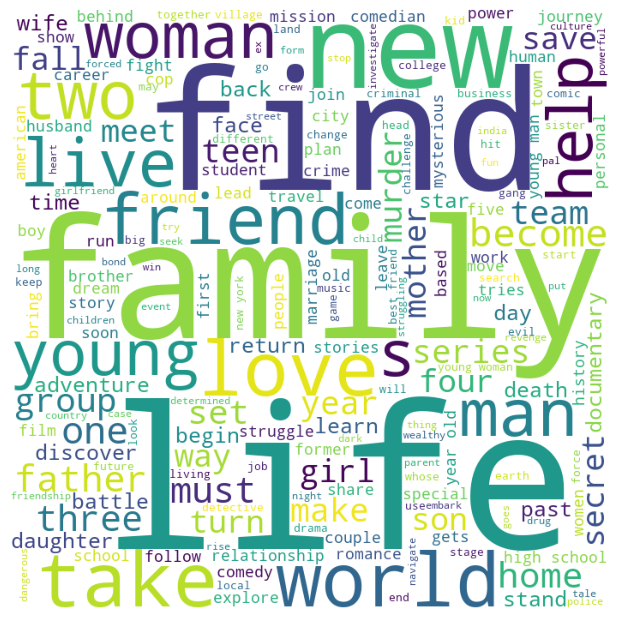

In [311]:
# Building a wordcloud for the movie descriptions
comment_words = ''
stopwords = set(STOPWORDS)

# iterate through the Description column
for val in df['description'].values:
    
    # typecaste each val to string
    val = str(val)

    # split the value
    tokens = val.split()
    
    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
    
    comment_words += " ".join(tokens)+" "
wordcloud = WordCloud(width = 700, height = 700,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)


# plot the WordCloud image                      
plt.figure(figsize = (10,6), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

* Some keywords in Netflix show descriptions: life, family, new, love, young, world, friend, group, death, man, woman, son, girl, murder, documentary, secret.

> # *6. Data preprocessing:*

* Modelling Approach:
    1. Select the attributes based on which you want to cluster the shows
    2. Text preprocessing: Remove all non-ascii characters, stopwords and punctuation marks, convert all textual data to lowercase.
    3. Lemmatization to generate a meaningful word out of corpus of words
    4. Tokenization of corpus
    5. Word vectorization
    6. Dimensionality reduction
    6. Use different algorithms to cluster the movies, obtain the optimal number of clusters using different techniques
    7. Build optimal number of clusters and visualize the contents of each cluster using wordclouds.

* We will cluster the shows on Netflix based on the following attributes:
    * Director
    * Cast
    * Country
    * Listed in (genres)
    * Description

In [238]:
# Using the original dataset for clustering since
# it does not require handling missing values
df1 = original_df.copy()

In [239]:
df1.fillna('',inplace=True)

In [240]:
# Combining all the clustering attributes into a single column

df1['clustering_attributes'] = (df1['director'] + ' ' + 
                                df1['cast'] +' ' + 
                                df1['country'] +' ' + 
                                df1['listed_in'] +' ' + 
                                df1['description'])

In [242]:
df1['clustering_attributes'][0]

' João Miguel, Bianca Comparato, Michel Gomes, Rodolfo Valente, Vaneza Oliveira, Rafael Lozano, Viviane Porto, Mel Fronckowiak, Sergio Mamberti, Zezé Motta, Celso Frateschi Brazil International TV Shows, TV Dramas, TV Sci-Fi & Fantasy In a future where the elite inhabit an island paradise far from the crowded slums, you get one chance to join the 3% saved from squalor.'

In [243]:
# function to remove non-ascii characters

def remove_non_ascii(words):
    """Function to remove non-ASCII characters"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

In [244]:
# remove non-ascii characters
df1['clustering_attributes'] = remove_non_ascii(df1['clustering_attributes'])

In [245]:
df1['clustering_attributes'][0]

' Joao Miguel, Bianca Comparato, Michel Gomes, Rodolfo Valente, Vaneza Oliveira, Rafael Lozano, Viviane Porto, Mel Fronckowiak, Sergio Mamberti, Zeze Motta, Celso Frateschi Brazil International TV Shows, TV Dramas, TV Sci-Fi & Fantasy In a future where the elite inhabit an island paradise far from the crowded slums, you get one chance to join the 3% saved from squalor.'

In [246]:
# remove stopwords and lower case
# extracting the stopwords from nltk library

import nltk
from nltk.corpus import stopwords
sw = stopwords.words('english')

# displaying the stopwords
np.array(sw)

array(['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you',
       "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself',
       'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her',
       'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them',
       'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom',
       'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are',
       'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had',
       'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and',
       'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at',
       'by', 'for', 'with', 'about', 'against', 'between', 'into',
       'through', 'during', 'before', 'after', 'above', 'below', 'to',
       'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under',
       'again', 'further', 'then', 'once', 'here', 'there', 'when',
       'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'm

In [247]:
# function to remove stop words
def stopwords(text):
    # removing the stop words and lowercasing the selected words
    text = [word.lower() for word in text.split() if word.lower() not in sw]
    return " ".join(text)

In [248]:
# Removing stop words
df1['clustering_attributes'] = df1['clustering_attributes'].apply(stopwords)

In [249]:
df1['clustering_attributes'][0]

'joao miguel, bianca comparato, michel gomes, rodolfo valente, vaneza oliveira, rafael lozano, viviane porto, mel fronckowiak, sergio mamberti, zeze motta, celso frateschi brazil international tv shows, tv dramas, tv sci-fi & fantasy future elite inhabit island paradise far crowded slums, get one chance join 3% saved squalor.'

In [250]:
# function to remove punctuations
def remove_punctuation(text):
    translator = str.maketrans('', '', string.punctuation)
    # return the text stripped of punctuation marks
    return text.translate(translator)

In [251]:
# Removing punctuation marks
df1['clustering_attributes'] = df1['clustering_attributes'].apply(remove_punctuation)

In [252]:
df1['clustering_attributes'][0]

'joao miguel bianca comparato michel gomes rodolfo valente vaneza oliveira rafael lozano viviane porto mel fronckowiak sergio mamberti zeze motta celso frateschi brazil international tv shows tv dramas tv scifi  fantasy future elite inhabit island paradise far crowded slums get one chance join 3 saved squalor'

In [253]:
# function to lemmatize the corpus
def lemmatize_verbs(words):
    # Lemmatize verbs in list of tokenized words
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    return lemmas

In [254]:
# Lemmatization
df1['clustering_attributes'] = lemmatize_verbs(df1['clustering_attributes'])

In [255]:
df1['clustering_attributes'][0]

'joao miguel bianca comparato michel gomes rodolfo valente vaneza oliveira rafael lozano viviane porto mel fronckowiak sergio mamberti zeze motta celso frateschi brazil international tv shows tv dramas tv scifi  fantasy future elite inhabit island paradise far crowded slums get one chance join 3 saved squalor'

In [256]:
# Tokenization
tokenizer = TweetTokenizer()

In [257]:
df1['clustering_attributes'] = df1['clustering_attributes'].apply(lambda x: tokenizer.tokenize(x))

## Vectorization:

* We can vectorize the corpus using TFIDF vectorizer, where TFIDF stands for - Term Frequency Inverse Document Frequency.

\begin{align}
        TF = \frac{Number\ of\ times\ term\ t\ appears\ in\ a\ document}{Total\ number\ of\ terms\ in\ the\ document}
    \end{align}

\begin{align}
        IDF(t) = log_e(\frac{Total\  number \ of \ documents}{ Number\ of\ documents\ with\ term\ t\ in\ it })
    \end{align}

\begin{align}
TFIDF = {TF\ *\ IDF}
    \end{align}

In [258]:
# clustering tokens saved in a variable
clustering_data = df1['clustering_attributes']

In [259]:
# Tokenization
def identity_tokenizer(text):
    return text

# Using TFIDF vectorizer to vectorize the corpus 
# max features = 20000 to prevent system from crashing

tfidf = TfidfVectorizer(tokenizer=identity_tokenizer, stop_words='english', lowercase=False,max_features = 20000)    
X = tfidf.fit_transform(clustering_data)

X

<7787x20000 sparse matrix of type '<class 'numpy.float64'>'
	with 235288 stored elements in Compressed Sparse Row format>

In [260]:
# Shape of X
X.shape

(7787, 20000)

In [261]:
# data type of vector
type(X)

scipy.sparse._csr.csr_matrix

In [262]:
# convert X into array form for clustering
X = X.toarray()
X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [263]:
# using PCA to reduce dimensionality
pca = PCA(random_state=42)
pca.fit(X)

PCA(random_state=42)

Text(0, 0.5, 'cumulative explained variance')

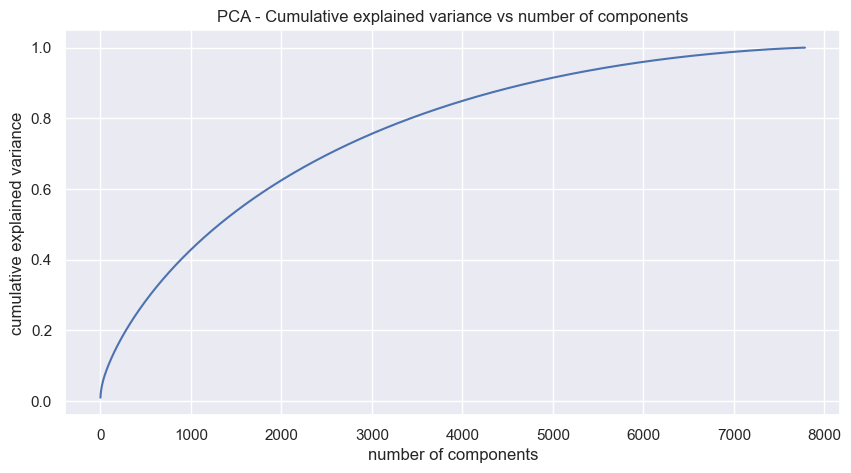

In [264]:
# Explained variance for different number of components
plt.figure(figsize=(10,5))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.title('PCA - Cumulative explained variance vs number of components')
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

* We find that ***100%*** of the variance is explained by about ***~7500 components***.
* Also, more than ***80%*** of the variance is explained just by ***4000 components***.
* Hence to simplify the model, and reduce dimensionality, we can take the top ***4000*** components, which will still be able to capture more than ***80%*** of variance.

In [265]:
# reducing the dimensions to 4000 using pca
pca = PCA(n_components=4000,random_state=42)
pca.fit(X)

PCA(n_components=4000, random_state=42)

In [266]:
# transformed features
x_pca = pca.transform(X)

In [267]:
# shape of transformed vectors
x_pca.shape

(7787, 4000)

We have successfully reduced the dimensionality of data using PCA.

> # *7. Clusters implementation:*

# K-Means Clustering:

* Building clusters using the K-means clustering algorithm.
* Visualizing the elbow curve and Silhouette score to decide on the optimal number of clusters for K-means clustering algorithm.

Text(0, 0.5, 'WCSS')

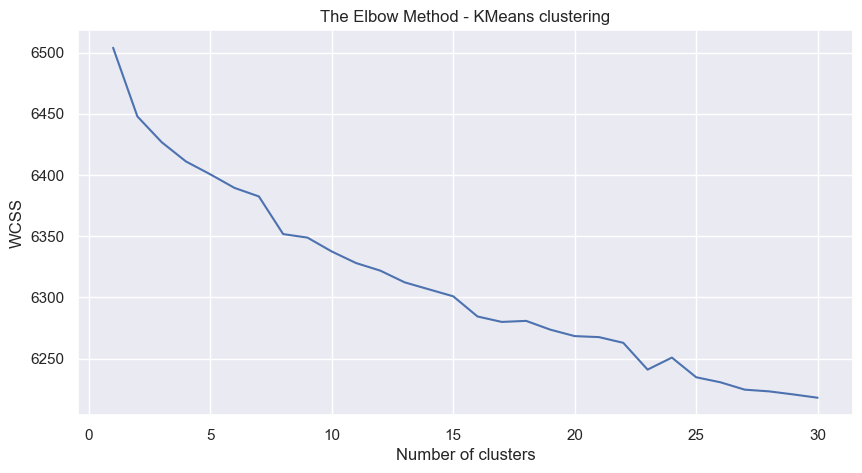

In [268]:
# Elbow method to find the optimal value of k
wcss=[]
for i in range(1,31):
  kmeans = KMeans(n_clusters=i,init='k-means++',random_state=33)
  kmeans.fit(x_pca)
  wcss_iter = kmeans.inertia_
  wcss.append(wcss_iter)

number_clusters = range(1,31)
plt.figure(figsize=(10,5))
plt.plot(number_clusters,wcss)
plt.title('The Elbow Method - KMeans clustering')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')

* The sum of squared distance between each point and the centroid in a cluster (WCSS) decreases with the increase in the number of clusters.

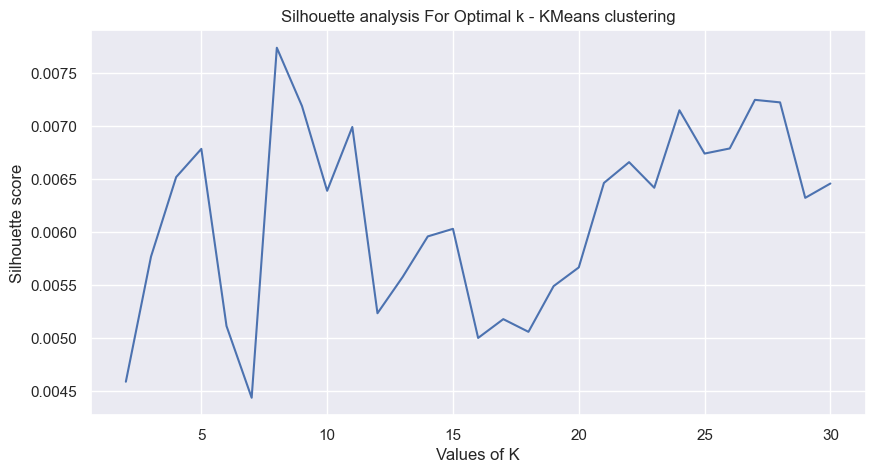

In [269]:
# Plotting Silhouette score for different umber of clusters
range_n_clusters = range(2,31)
silhouette_avg = []
for num_clusters in range_n_clusters:
  # initialize kmeans
  kmeans = KMeans(n_clusters=num_clusters,init='k-means++',random_state=33)
  kmeans.fit(x_pca)
  cluster_labels = kmeans.labels_
 
  # silhouette score
  silhouette_avg.append(silhouette_score(x_pca, cluster_labels))

plt.figure(figsize=(10,5))
plt.plot(range_n_clusters,silhouette_avg)
plt.xlabel('Values of K') 
plt.ylabel('Silhouette score')
plt.title('Silhouette analysis For Optimal k - KMeans clustering')
plt.show()

* The highest Silhouette score is obtained for 6 clusters.

In [270]:
# Clustering the data into 6 clusters
kmeans = KMeans(n_clusters=6,init='k-means++',random_state=33)
kmeans.fit(x_pca)

KMeans(n_clusters=6, random_state=33)

In [271]:
# Evaluation metrics - distortion, Silhouette score
kmeans_distortion = kmeans.inertia_
kmeans_silhouette_score = silhouette_score(x_pca, kmeans.labels_)

print((kmeans_distortion,kmeans_silhouette_score))

(6389.413249516617, 0.00511604032223989)


In [272]:
# Adding a kmeans cluster number attribute
df1['kmeans_cluster'] = kmeans.labels_

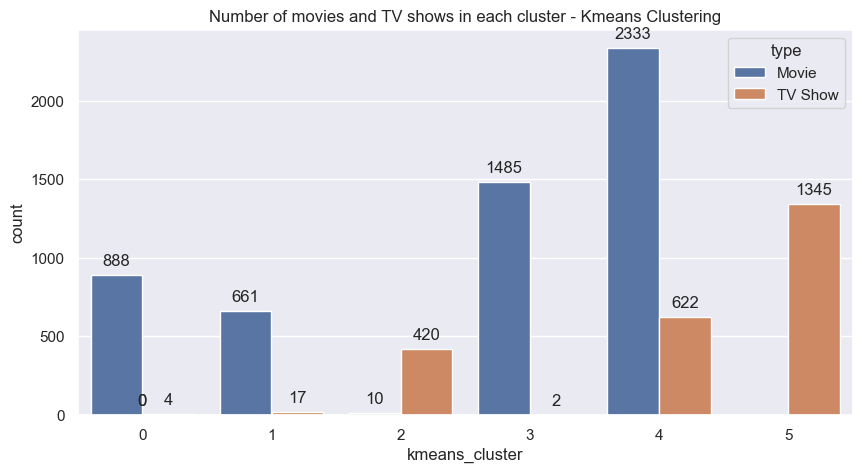

In [273]:
# Number of movies and tv shows in each cluster
plt.figure(figsize=(10,5))
q = sns.countplot(x='kmeans_cluster',data=df1, hue='type')
plt.title('Number of movies and TV shows in each cluster - Kmeans Clustering')
for i in q.patches:
  q.annotate(format(i.get_height(), '.0f'), (i.get_x() + i.get_width() / 2., i.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

* Successfully built 6 clusters using the k-means clustering algorithm.

In [274]:
# Building a wordcloud for the movie descriptions
def kmeans_worldcloud(cluster_num):
  comment_words = ''
  stopwords = set(STOPWORDS)

  # iterate through the csv file
  for val in df1[df1['kmeans_cluster']==cluster_num].description.values:
      
      # typecaste each val to string
      val = str(val)

      # split the value
      tokens = val.split()
      
      # Converts each token into lowercase
      for i in range(len(tokens)):
          tokens[i] = tokens[i].lower()
      
      comment_words += " ".join(tokens)+" "

  wordcloud = WordCloud(width = 700, height = 700,
                  background_color ='white',
                  stopwords = stopwords,
                  min_font_size = 10).generate(comment_words)


  # plot the WordCloud image                      
  plt.figure(figsize = (10,5), facecolor = None)
  plt.imshow(wordcloud)
  plt.axis("off")
  plt.tight_layout(pad = 0)

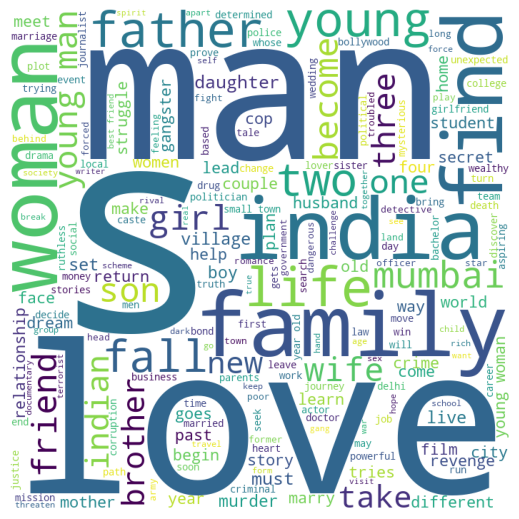

In [275]:
# Wordcloud for cluster 0
kmeans_worldcloud(0)

* Keywords observed in cluster 0: love, man, woman, mumbai, india, family, father, young, life, son 

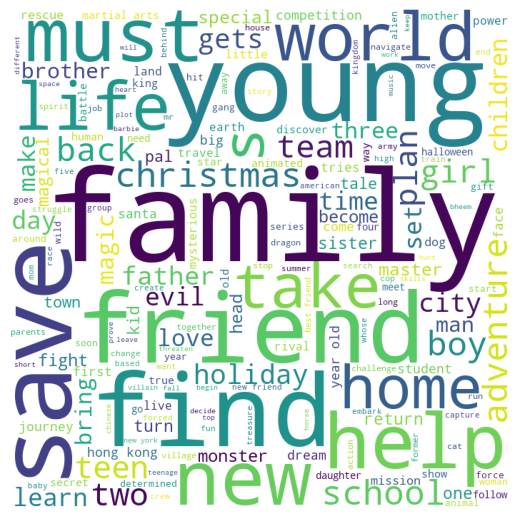

In [276]:
# Wordcloud for cluster 1
kmeans_worldcloud(1)

* Keywords observed in cluster 1: life, love, family, father, young, girl, man, woman, friend, daughter, secret

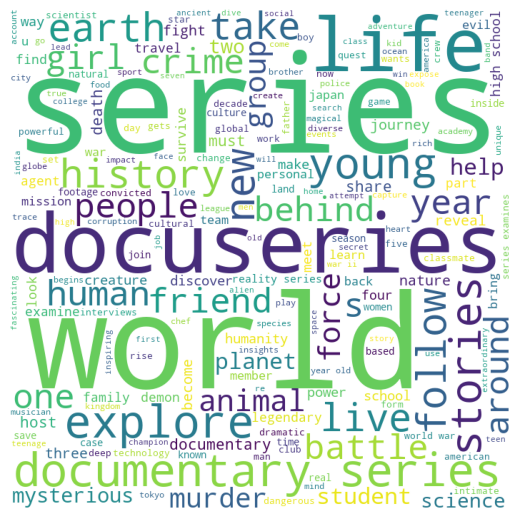

In [277]:
# Wordcloud for cluster 2
kmeans_worldcloud(2)

* Keywords observed in cluster 2: life, world, girl, adventure,family, discover, group, boy, death

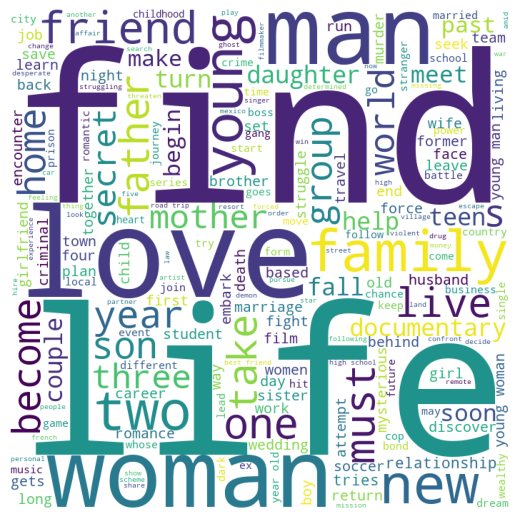

In [278]:
# Wordcloud for cluster 3
kmeans_worldcloud(3)

* Keywords observed in cluster 3: love, life, family, romance, crime, murder, world, adventure, woman

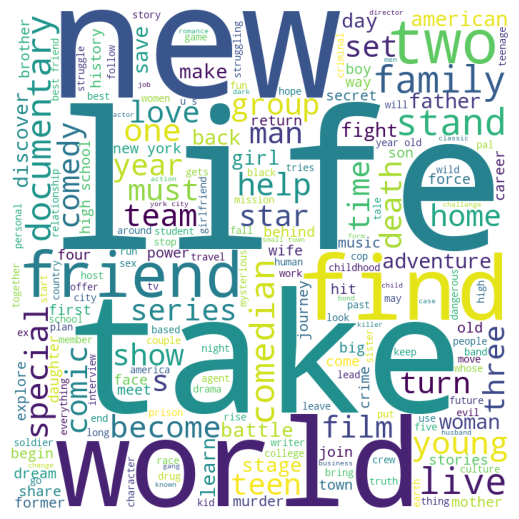

In [279]:
# Wordcloud for cluster 4
kmeans_worldcloud(4)

* Keywords observed in cluster 4: documentary, film, activist, comedian, special, stand, comic, stage, sex, joke

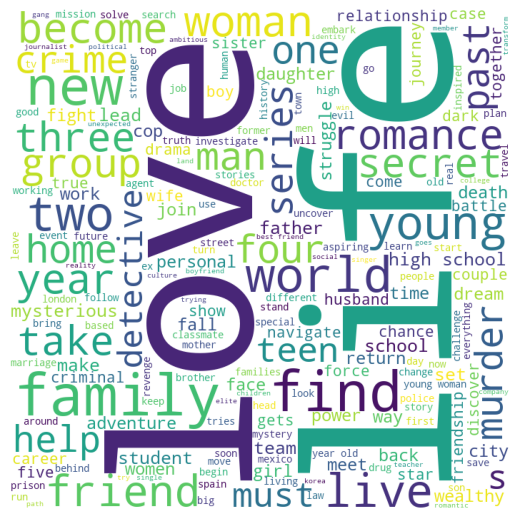

In [280]:
# Wordcloud for cluster 5
kmeans_worldcloud(5)

* Keywords observed in cluster 5: comedian, stand, special, stage, comic, funny, comedy, life

#  Hierarchical clustering:

* Building clusters using the agglomerative (hierarchical) clustering algorithm.
* Visualizing the dendrogram to decide on the optimal number of clusters for the agglomerative (hierarchical) clustering algorithm

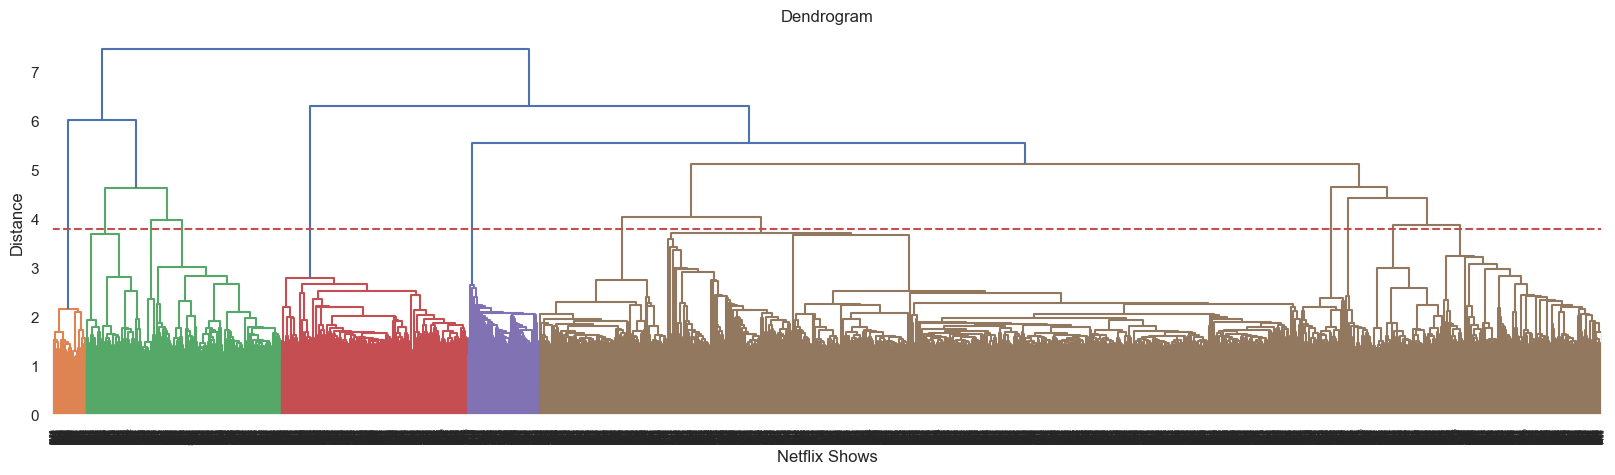

In [281]:
# Building a dendogram to decide on the number of clusters
plt.figure(figsize=(20, 5))  
dend = shc.dendrogram(shc.linkage(x_pca, method='ward'))
plt.title('Dendrogram')
plt.xlabel('Netflix Shows')
plt.ylabel('Distance')
plt.axhline(y= 3.8, color='r', linestyle='--')

* At a distance of around 3.8 units, 12 clusters can be built using the agglomerative clustering algorithm.
* Building 12 clusters using the Agglomerative clustering algorithm

In [282]:
# Fitting hierarchical clustering model
hierarchical = AgglomerativeClustering(n_clusters=12, linkage='ward')  
hierarchical.fit_predict(x_pca)

array([3, 5, 1, ..., 4, 2, 4], dtype=int64)

In [283]:
# Adding a kmeans cluster number attribute
df1['hierarchical_cluster'] = hierarchical.labels_

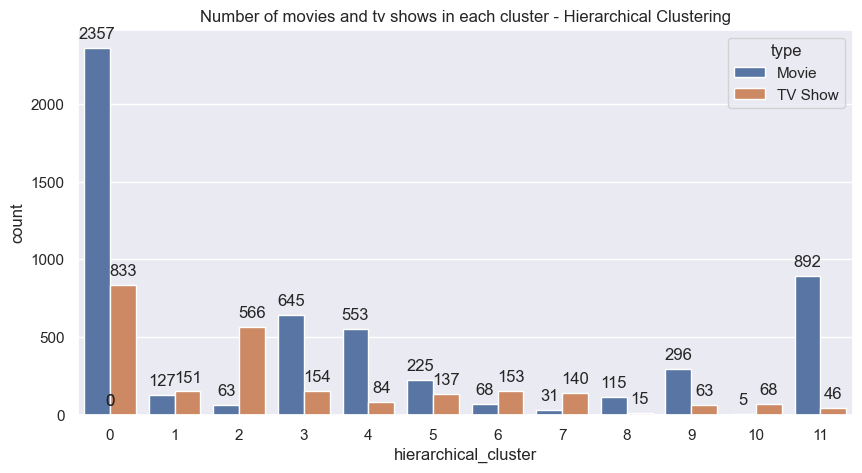

In [284]:
# Number of movies and tv shows in each cluster
plt.figure(figsize=(10,5))
q = sns.countplot(x='hierarchical_cluster',data=df1, hue='type')
plt.title('Number of movies and tv shows in each cluster - Hierarchical Clustering')
for i in q.patches:
  q.annotate(format(i.get_height(), '.0f'), (i.get_x() + i.get_width() / 2., i.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

* Successfully built 12 clusters using the Agglomerative (hierarchical) clustering algorithm.

In [285]:
# Building a wordcloud for the movie descriptions
def hierarchical_worldcloud(cluster_num):
  comment_words = ''
  stopwords = set(STOPWORDS)

  # iterate through the csv file
  for val in df1[df1['hierarchical_cluster']==cluster_num].description.values:
      
      # typecaste each val to string
      val = str(val)

      # split the value
      tokens = val.split()
      
      # Converts each token into lowercase
      for i in range(len(tokens)):
          tokens[i] = tokens[i].lower()
      
      comment_words += " ".join(tokens)+" "

  wordcloud = WordCloud(width = 700, height = 700,
                  background_color ='white',
                  stopwords = stopwords,
                  min_font_size = 10).generate(comment_words)


  # plot the WordCloud image                      
  plt.figure(figsize = (10,5), facecolor = None)
  plt.imshow(wordcloud)
  plt.axis("off")
  plt.tight_layout(pad = 0)

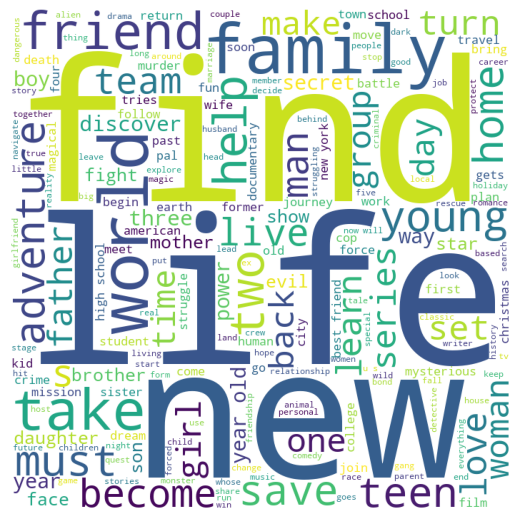

In [286]:
# Wordcloud for cluster 0
hierarchical_worldcloud(0)

**Keywords observed in cluster 0: life, new, find, family, save, friend, young, teen, adventure**

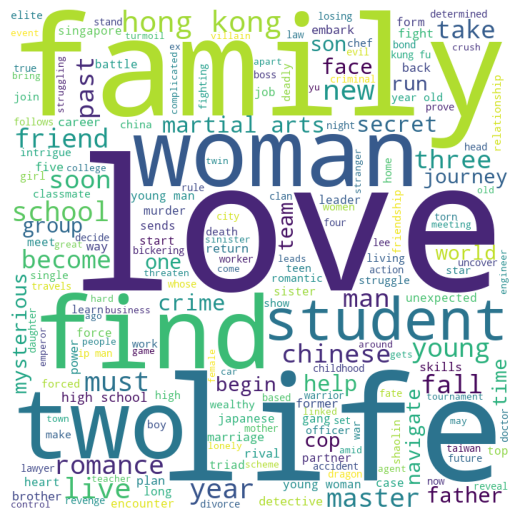

In [287]:
# Wordcloud for cluster 1
hierarchical_worldcloud(1)

* Keywords observed in cluster 1: love, family, life, student, romance, school, woman, master, father

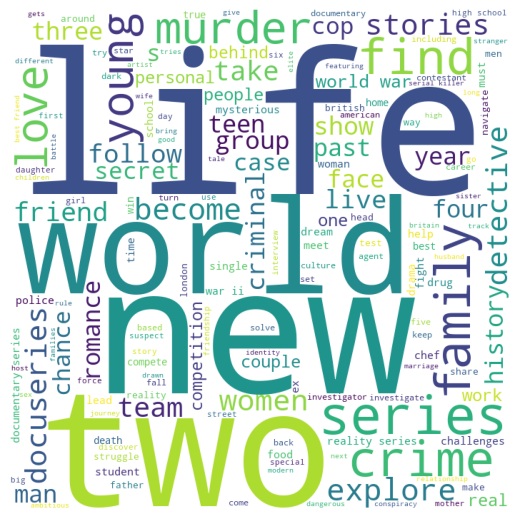

In [288]:
# Wordcloud for cluster 2
hierarchical_worldcloud(2)

* Keywords observed in cluster 2: life, new, family, young, team, detective, history, murder

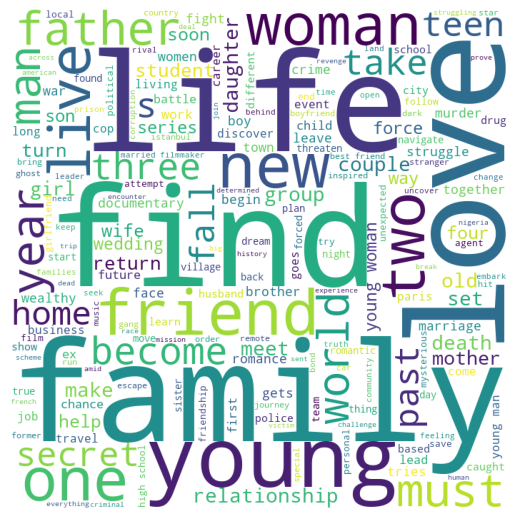

In [289]:
# Wordcloud for cluster 3
hierarchical_worldcloud(3)

* Keywords observed in cluster 3: series, explore, documentary, life, stories, earth, murder, crime

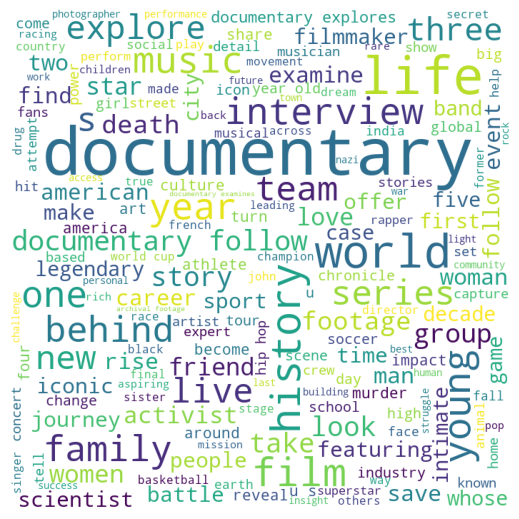

In [290]:
# Wordcloud for cluster 4
hierarchical_worldcloud(4)

* Keywords observed in cluster 4: documentary, music, explore, career, film, history, interview, friend, world, life

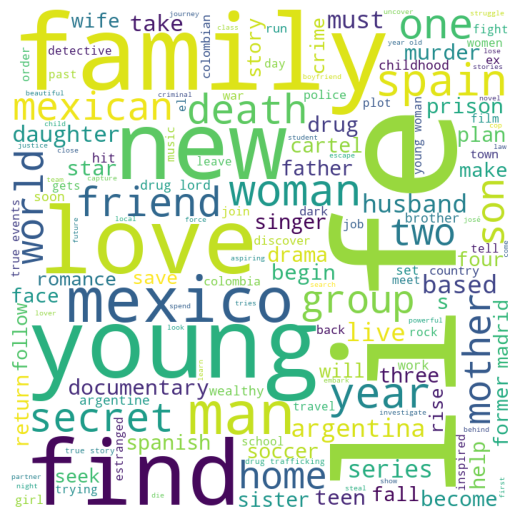

In [291]:
# Wordcloud for cluster 5
hierarchical_worldcloud(5)

* Keywords observed in cluster 5: family, life, father, young, new, love, man, mumbai, brother, wife, indian

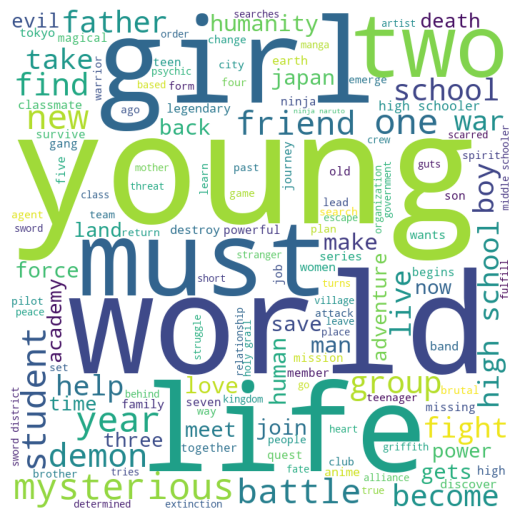

In [292]:
# Wordcloud for cluster 6
hierarchical_worldcloud(6)

* Keywords observed in cluster 6: young, life, girl, world, friend, mysterious, demon, student, human, war

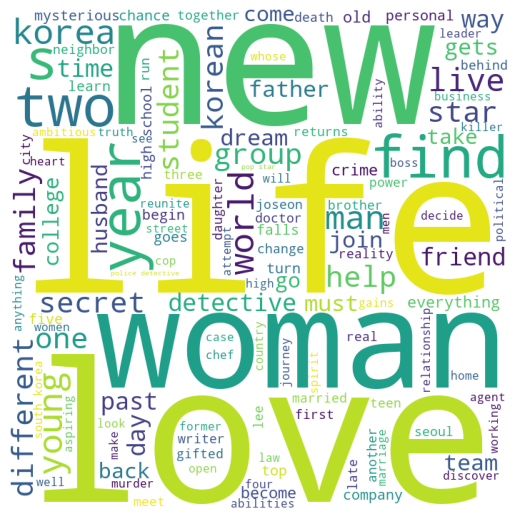

In [293]:
# Wordcloud for cluster 7
hierarchical_worldcloud(7)

* Keywords observed in cluster 7: love, life, man, new, woman, student, father, korea, secret, reality, star

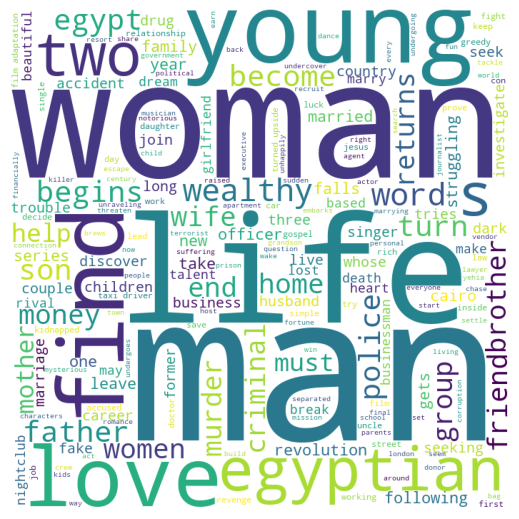

In [294]:
# Wordcloud for cluster 8
hierarchical_worldcloud(8)

* Keywords observed in cluster 8: woman, man, life, egyptian, wealthy, love, money, young, world, love, friend, group

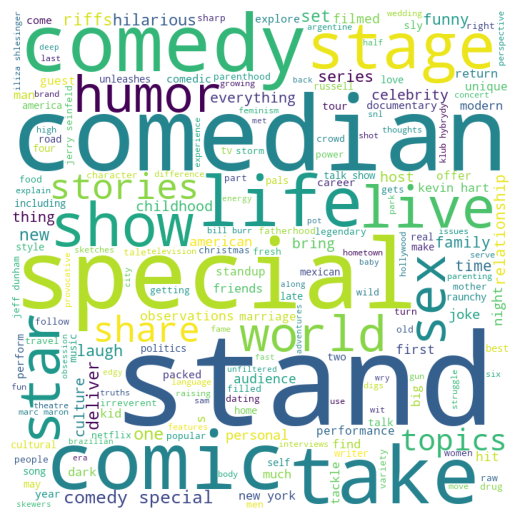

In [295]:
# Wordcloud for cluster 9
hierarchical_worldcloud(9)

* Keywords observed in cluster 9: comedian, stand, life, comic, special, show, live, star, stage, hilarious, stories

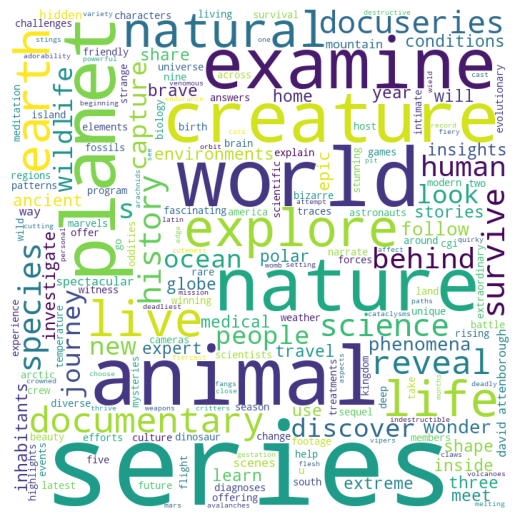

In [296]:
# Wordcloud for cluster 10
hierarchical_worldcloud(10)

* Keywords observed in cluster 10: hong kong, chinese, japanese, animal, family, officer, school, young

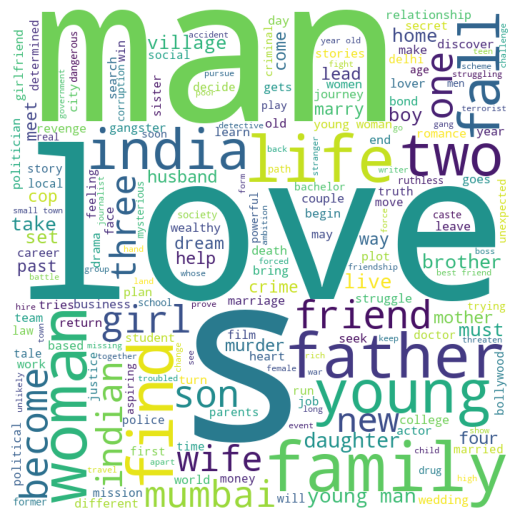

In [297]:
# Wordcloud for cluster 11
hierarchical_worldcloud(11)

* Keywords observed in cluster 11: love, man, woman, school, world, romance, family, friend, year, student

> # 8. Content based recommender system:

* We can build a simple content based recommender system based on the similarity of the shows.
* If a person has watched a show on Netflix, the recommender system must be able to recommend a list of similar shows that s/he likes.
* To get the similarity score of the shows, we can use cosine similarity
* The similarity between two vectors (A and B) is calculated by taking the dot product of the two vectors and dividing it by the magnitude value as shown in the equation below. We can simply say that the CS score of two vectors increases as the angle between them decreases.

\begin{align}
        Cos(\theta) = \frac{A\ .\ B}{|A|\ .\ |B|}
    \end{align}

In [298]:
# defining a new df for building a recommender system
recommender_df = df1.copy()

In [299]:
# Changing the index of the df from show id to show title
recommender_df['show_id'] = recommender_df.index

In [300]:
# converting tokens to string
def convert(lst):
  return ' '.join(lst)

recommender_df['clustering_attributes'] = recommender_df['clustering_attributes'].apply(lambda x: convert(x))

In [301]:
# setting title of movies/Tv shows as index
recommender_df.set_index('title',inplace=True)

In [302]:
# Count vectorizer
CV = CountVectorizer()
converted_matrix = CV.fit_transform(recommender_df['clustering_attributes'])

In [303]:
# Cosine similarity
cosine_similarity = cosine_similarity(converted_matrix)

In [304]:
cosine_similarity.shape

(7787, 7787)

In [305]:
# Developing a function to get 10 recommendations for a show
indices = pd.Series(recommender_df.index)

def recommend_10(title, cosine_sim = cosine_similarity):
  try:
    recommend_content = []   
    idx = indices[indices == title].index[0]
    series = pd.Series(cosine_sim[idx]).sort_values(ascending = False)
    top10 = list(series.iloc[1:11].index)
    # list with the titles of the best 10 matching movies
    for i in top10:
      recommend_content.append(list(recommender_df.index)[i])
    print("If you liked '"+title+"', you may also enjoy:\n")
    return recommend_content

  except:
    return 'Invalid Entry'

In [306]:
# Recommendations for 'A Man Called God'
recommend_10('A Man Called God')

If you liked 'A Man Called God', you may also enjoy:



['Mr. Sunshine',
 'One Spring Night',
 'Rugal',
 'The King: Eternal Monarch',
 'My Mister',
 'My Little Baby',
 'Reply 1994',
 'Extracurricular',
 'My Secret Romance',
 'Chef & My Fridge']

In [307]:
# Recommendations for 'Stranger Things'
recommend_10('Stranger Things')

If you liked 'Stranger Things', you may also enjoy:



['Beyond Stranger Things',
 'Prank Encounters',
 'The Umbrella Academy',
 'Haunted',
 'Scream',
 'Warrior Nun',
 'Nightflyers',
 'Zombie Dumb',
 'Kiss Me First',
 'The Vampire Diaries']

In [308]:
# Recommendations for 'Peaky Blinders'
recommend_10('Peaky Blinders')

If you liked 'Peaky Blinders', you may also enjoy:



['Kiss Me First',
 'Happy Valley',
 'London Spy',
 'The Frankenstein Chronicles',
 'Paranoid',
 'Get Even',
 'Giri / Haji',
 'My Hotter Half',
 'The Murder Detectives',
 'I AM A KILLER: RELEASED']

In [309]:
# Recommendations for 'Lucifer'
recommend_10('Lucifer')

If you liked 'Lucifer', you may also enjoy:



['Rica, Famosa, Latina',
 'Get Shorty',
 'The Good Cop',
 'Jack Taylor',
 'Better Call Saul',
 'Dramaworld',
 'Father Brown',
 "Marvel's Iron Fist",
 'Young Wallander',
 'No Good Nick']

In [310]:
# Recommendations for 'XXX'
recommend_10('XXX')

'Invalid Entry'

* Invalid because the show 'XXX' is not available on Netflix.

> # 9. Conclusions

* In this project, we worked on a text clustering problem wherein we had to classify/group the Netflix shows into certain clusters such that the shows within a cluster are similar to each other and the shows in different clusters are dissimilar to each other.
* The dataset contained about 7787 records, and 11 attributes.
* We began by dealing with the dataset's missing values and doing exploratory data analysis (EDA).
* It was found that Netflix hosts more movies than TV shows on its platform, and the total number of shows added on Netflix is growing exponentially. Also, majority of the shows were produced in the United States, and the majority of the shows on Netflix were created for adults and young adults age group.
* It was decided to cluster the data based on the attributes: director, cast, country, genre, and description. The values in these attributes were tokenized, preprocessed, and then vectorized using TFIDF vectorizer.
* Through TFIDF Vectorization, we created a total of 20000 attributes.
* We used Principal Component Analysis (PCA) to handle the curse of dimensionality. 4000 components were able to capture more than 80% of variance, and hence, the number of components were restricted to 4000.
* We first built clusters using the k-means clustering algorithm, and the optimal number of clusters came out to be 6. This was obtained through the elbow method and Silhouette score analysis. 
* Then clusters were built using the Agglomerative clustering algorithm, and the optimal number of clusters came out to be 12. This was obtained after visualizing the dendrogram.
* A content based recommender system was built using the similarity matrix obtained after using cosine similarity. This recommender system will make 10 recommendations to the user based on the type of show they watched.